## Functions to calculate streamflow metrics

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import ticker
from importlib import reload
from dataretrieval import nwis
from datetime import timedelta

import os
import warnings
import calendar
#import pymannkendall as mk

from datetime import datetime
import timeit

In [61]:
# Variables
# NOTE: Validation for SRB outlet gage
site_no = '11447650'
#site_no = '11303500'
DEFAULT_START = '1930-10-01'
DEFAULT_END = '2014-09-30' # end date for Kocis paper
data_range = 30
MAX_MISSING_THRESHOLD = 0.10
quantile = 0.9
SEC_PER_DAY = 86400
HYDRO_YEAR = 'AS-OCT'
CUBIC_FT_KM_FACTOR = 0.0000000000283168466
MAF_to_km3 = 1e6 * 43560 * 0.0283 * 1e-9

In [62]:
# Download streamflow data
def download_usgs_data(site_no, start_date, end_date):
    df = nwis.get_record(sites=str(site_no), service='dv', start=start_date, end=end_date, parameterCd='00060').rename(columns={'00060_Mean': 'flow_cfs'})
    #df = nwis.get_record(sites=str(site_no), service='dv', start=start_date, end=end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
    return df

df = download_usgs_data(site_no, DEFAULT_START, DEFAULT_END)

## Validation (missing less than 10% of dates over date range)

Start of 30-year record: 1984-09-30
Start of gage record: 1948-10-01 00:00:00+00:00
End of gage record: 2014-09-30 00:00:00+00:00
Valid: True -- Missing -120.0055%


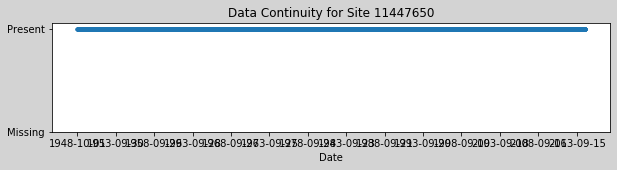

In [63]:
def validate(df: pd.DataFrame, start: datetime, end: datetime):
    """Returns the % amount of data missing from the analyzed range"""
    t_delta = pd.to_datetime(end) - pd.to_datetime(start)
    days = t_delta.days
    missing = 1.0 - (len(df) / days)   # len of df is record of usgs gauge and days is number of days in past 30 years        
    return missing

# Reset the index to numbers (not dates)
df_valid = df.reset_index()

# "start" is 30 years (or other data range) before the default end date (not the last date of the df)
start = pd.to_datetime(DEFAULT_END).date() - timedelta(days=365.25 * data_range)
print(f'Start of 30-year record: {start}')

# Restrict df to all dates after the theorectical start date
#df_valid = df_valid[df_valid['datetime'].dt.date >= start]
start_df = df_valid['datetime'].iloc[0]
end_df = df_valid['datetime'].iloc[-1]
print(f'Start of gage record: {start_df}')
print(f'End of gage record: {end_df}')

# Create a new column where each date present equals 1
df_valid['00060_Mean'] = 1 

missing = validate(df_valid, start, DEFAULT_END)
print(f"Valid: {missing < MAX_MISSING_THRESHOLD} -- Missing {missing * 100:.4f}%")

# Create missing dates and set their values to 0
complete_range = pd.date_range(start=start, end=DEFAULT_END, freq='D') # daily dates for selected record length (e.g., 30 years)
df_complete = pd.DataFrame({'datetime': complete_range})
df_valid = pd.concat([df_complete.set_index('datetime').tz_localize(None), df_valid.set_index('datetime').tz_localize(None)], axis=1, join='outer').fillna(0).reset_index()

plt.figure(figsize=(10, 2), facecolor='lightgray')
plt.plot(df_valid['datetime'], df_valid['00060_Mean'], marker='.', linestyle='dotted')

plt.yticks([0, 1], ['Missing', 'Present'])
plt.xticks(df_valid['datetime'][::(365*5)]) # syntax: start:stop:step (step of 5 years)
plt.xlabel("Date")

plt.title(f"Data Continuity for Site {site_id}")
plt.show()

##  Threshold Calculation

Threshold: 52350.0 cfs


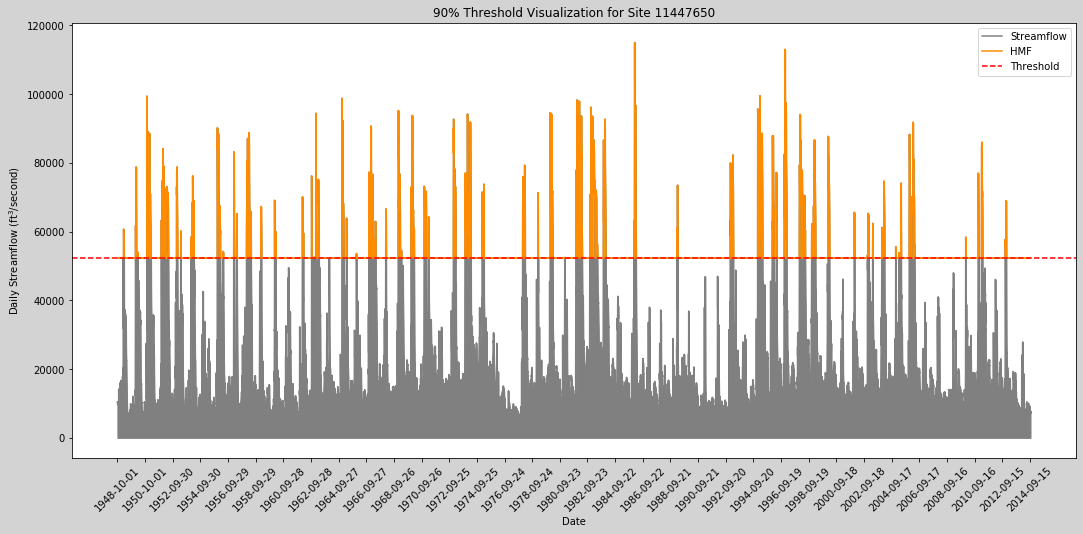

In [64]:
def calc_threshold(df: pd.DataFrame, value: float):
    """Returns a threshold above which flow is considered HMF given flow values and a threshold 0 < t < 1""" 
    df = pd.DataFrame(df['flow_cfs'])
    return df.quantile(q=value, axis=0).iloc[0]

df = download_usgs_data(site_no, DEFAULT_START, DEFAULT_END)
df_threshold = df.reset_index()

#start = pd.to_datetime(DEFAULT_END).date() - timedelta(days=365.25 * data_range)
#df_threshold = df_threshold[df_threshold['datetime'].dt.date >= start]

# Add this line of code for plotting (set index as 'datetime', remove timezone which can cause issues, reset index)
df_threshold = df_threshold.set_index('datetime').tz_localize(None).reset_index()

#print(df_threshold)
      
threshold = calc_threshold(df_threshold, quantile)
print(f"Threshold: {threshold} cfs")

df_threshold["diff"] = df_threshold['flow_cfs'] - threshold
df_threshold["hmf"] = df_threshold["diff"].apply(lambda x: max(0, x)) + threshold
#print(df_threshold)

plt.figure(figsize=(18, 8), facecolor='lightgray')
plt.plot(df_threshold['datetime'], df_threshold['flow_cfs'], label="Streamflow", color="gray")
plt.plot(df_threshold['datetime'], df_threshold["hmf"], label="HMF", color="darkorange")
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

plt.fill_between(df_threshold["datetime"], df_threshold["flow_cfs"], color="gray")
plt.fill_between(df_threshold["datetime"], y1=threshold, y2=df_threshold["hmf"], color="orange")

plt.xticks(df_threshold['datetime'][::(365*2)], rotation=45)
plt.xlabel("Date")

plt.ylabel('Daily Streamflow ($\mathregular{ft^3}$/second)')

plt.title(f"{quantile*100:.0f}% Threshold Visualization for Site {site_id}")
plt.legend()
plt.show()

## Metric: Total Annual Magnitude

In [98]:
def filter_hmf(df: pd.DataFrame, threshold: float):
    """Returns a dataframe with only flow values above a given threshold present, and a second with non-HMF years zero deflated"""
    hmf_series_cont = df.copy()
    hmf_series_defl = df[df['flow_cfs'] > threshold]    
    hmf_series_cont['flow_cfs'] = hmf_series_cont['flow_cfs'].apply(lambda x: x if x >= threshold else 0) 
    return hmf_series_defl, hmf_series_cont

def convert_hmf(df: pd.DataFrame, threshold: float):
    """Converts flow values from ft^3/s to ft^3/day and returns the difference in flow above the threshold"""
    df['flow_cfd'] = (df['flow_cfs'] - threshold) * SEC_PER_DAY
    return df

def num_hmf_years(df: pd.DataFrame, offset: int):
    """Returns the integer number of HMF years, using an offset to indicate the start of the Hydrologic Year (i.e. 10 = October)"""
    df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)    
    df.loc[:, 'offsetdate'] = (df.index - pd.offsets.YearBegin(month=offset))    
    return df['offsetdate'].dt.year.nunique()

df_annualhmf = df.reset_index()

#start = pd.to_datetime(DEFAULT_END).date() - timedelta(days=365.25 * data_range)
#df_annualhmf = df_annualhmf[df_annualhmf['datetime'].dt.date >= start]

threshold = calc_threshold(df_annualhmf, quantile)
hmf_series_defl, hmf_series_cont = filter_hmf(df_annualhmf, threshold)
hmf_series_defl = convert_hmf(hmf_series_defl, threshold)

hmf_years = num_hmf_years(hmf_series_defl, 10)
total_hmf_flow = hmf_series_defl["flow_cfd"].sum()
total_hmf_flow = (total_hmf_flow * CUBIC_FT_KM_FACTOR) / hmf_years

print(f"Average Annual HMF: {total_hmf_flow:.2f} km^3/year")

# # Filtering out 0 years since average is calculated using only non-zero years
# # and this will make the visualization more accurate
# annual_sum = annual_sum[annual_sum > 0]

# fig = plt.figure(figsize=(9, 7), facecolor='lightgray')
# plt.bar(range(len(annual_sum.index)), annual_sum, color='orange')
# plt.axhline(y=threshold, color='r', linestyle='--')

# plt.xlabel('Hydro Year (zero years omitted)')
# plt.xticks(range(len(annual_sum.index)), annual_sum.index.strftime('%Y'), rotation=45)
# plt.ylabel('Annual HMF ($\mathregular{km^3}$/year)')

# plt.title(f'Annual HMF for Site {site_id}')
# plt.legend(['Average Annual HMF', 'HMF'])
# plt.show()

Average Annual HMF: 2.11 km^3/year


C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\kondr\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\kondr\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [99]:
# KO Magntide calculation

# Create a df with of the hmf flows for all days of the streamflow record
def calc_hmf(df, threshold):
    flow_above_threshold_list = [(flow - threshold) if flow > threshold else 0 for flow in df['flow_cfs']]
    df['flow_cfs'] = flow_above_threshold_list
    return df

def calc_mag_maf(df):
    df.set_index('datetime', inplace=True)
    annual_vol_abv_threshold = df['flow_cfs'].resample('AS-OCT').sum() * 86400 / 43560 / 1e6 # MAF, total flow above threshold for all years (including non-HMF years)
    return annual_vol_abv_threshold # returns series

def calc_zero_deflated_mean(annual_timeseries):
    avg_metric = annual_timeseries[annual_timeseries != 0].dropna().mean()
    return avg_metric

# Calculate the hmf df
df_threshold = df.reset_index()
df_threshold = df_threshold.set_index('datetime').tz_localize(None).reset_index()
hmf_df = calc_hmf(df_threshold, threshold)

# Calculate the average annual magntiude of high flows 
annual_mag_series = calc_mag_maf(hmf_df)
annual_avg_mag_maf = calc_zero_deflated_mean(annual_mag_series)
annual_avg_mag_km3 = annual_avg_mag_maf * MAF_to_km3

print(f"Average Annual HMF: {annual_avg_mag_maf:.2f} MAF/year")
print(f"Average Annual HMF: {annual_avg_mag_km3:.2f} km^3/year")
print(annual_mag_series * MAF_to_km3)

Average Annual HMF: 1.71 MAF/year
Average Annual HMF: 2.11 km^3/year
datetime
1948-10-01    0.160767
1949-10-01    0.326424
1950-10-01    3.153227
1951-10-01    5.205538
1952-10-01    1.044555
                ...   
2009-10-01    0.045479
2010-10-01    2.192172
2011-10-01    0.000000
2012-10-01    0.259916
2013-10-01    0.000000
Freq: AS-OCT, Name: flow_cfs, Length: 66, dtype: float64


## Metric: Duration, Event Duration, Intra-Annual Frequency, and Event Magnitude

In [100]:
def calc_duration_intra_annual(df: pd.DataFrame, hmf_years: int, threshold): ## EDIT (add threshold)
    """Calculates the average duration of HMF events per year and the intra-annual frequency of events
       per year. Also returns a results dataframe for use in the duration and intra-annual MK tests"""
    df_d = df.reset_index()
    df_d['datetime'] = df_d['datetime'] + pd.DateOffset(months=-9)
    
    ## NEW: Note new column name for the converted hmf is 'flow_cfd' so that there are separate columns for flow in cfs and flow in cfd
    df_d = convert_hmf(df_d, threshold)

    # EDIT: Create a binary column for HMF events; rename column to keep flow values for event magnitude calculation
    df_d['hmf'] = df_d['flow_cfs'].apply(lambda x: 1 if x > 0 else 0)

    # Initialize results dataframe with required years 
    years = list(range(df_d["datetime"].dt.year.min(), df_d["datetime"].dt.year.max() + 1))
    
    ## EDIT: Add column for 'total_mag'
    df_results = pd.DataFrame({'year': years, 'total_days': [0] * len(years), 'total_events': [0] * len(years), 'total_mag': [0] * len(years)})
    
    # Check each day for an HMF event, if one occurs add it to total days, 
    # and if it's the first day of an event add it to total events
    event = False
    for _, row in df_d.iterrows():    
        if row["hmf"] == 1:
            if not event: # If event hasn't already been recorded
                df_results.loc[df_results['year'] == row['datetime'].year, 'total_events'] += 1    
                        
            df_results.loc[df_results['year'] == row['datetime'].year, 'total_days'] += 1
            ## NEW: Add flow values (in cfd) for days with hmf, and convert to km3
            df_results.loc[df_results['year'] == row['datetime'].year, 'total_mag'] += row['flow_cfd'] * CUBIC_FT_KM_FACTOR
            event = True
        else:
            event = False
                            
    df_results['duration'] = df_results['total_days'] / df_results['total_events']
    df_results['duration'].fillna(0, inplace=True)
    
    ## NEW
    df_results['event_mag'] = df_results['total_mag'] / df_results['total_events']
    df_results['event_mag'].fillna(0, inplace=True)
    
    # Annual, Event, and Intra-annual calculations
    annual_duration = df_results['total_days'].sum() / hmf_years    
    event_duration = df_results['duration'].sum() / hmf_years
    intra_annual = df_results['total_events'].sum() / hmf_years
    ## NEW
    event_magnitude = df_results['event_mag'].sum() / hmf_years
    
    #E EDIT
    return event_duration, annual_duration, intra_annual, event_magnitude, df_results

hmf_series_defl, hmf_series_cont = filter_hmf(df_annualhmf, threshold)
event_duration, annual_duration, intra_annual, event_magnitude, df_results = calc_duration_intra_annual(hmf_series_cont, hmf_years, threshold)

print(f"Average Annual HMF Duration: {annual_duration:.2f} days/year")
print(f"Average Event HMF Duration: {event_duration:.2f} days/event")
print(f"Average Frequency of HMF Events: {intra_annual:.2f} events/year")
print(f"Average Magnitude of HMF Events: {event_magnitude:.2f} km3/event")

Average Annual HMF Duration: 51.30 days/year
Average Event HMF Duration: 20.00 days/event
Average Frequency of HMF Events: 2.60 events/year
Average Magnitude of HMF Events: 0.85 km3/event


In [97]:
# OLD ANNUAL DURATION CALC
# def calc_duration(df: pd.DataFrame):
#     """Returns the total number of HMF days over the dataframes time period"""
#     df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])
#     df.set_index('datetime', inplace=True)  
#     df_results = df.resample(HYDRO_YEAR).agg({'flow_cfs': ['count']})
#     df_results.columns = ['Count']
#     return df_results['Count'].sum() / hmf_years, df_results

# hmf_series_defl, hmf_series_cont = filter_hmf(df_annualhmf, threshold)

# # KO NOTE: hmf_series above is the total flow on days that are above the threshold and 0 for days below the threshold
# # Fix so hmf_series is the flow above the threshold

# avg_duration, annual_duration_series = calc_duration(hmf_series_cont)
# print(f"Average Annual HMF Duration: {avg_duration:.2f} days/year")
# print('Average and duration series match with KO calculation below')
# print(annual_duration_series)
# print('Average and duration series match with KO calculation below')

# # KO NOTE: hmf_series above is the total flow on days that are above the threshold and 0 for days below the threshold
# # Fix so hmf_series is the flow above the threshold

# avg_duration, annual_duration_series = calc_duration(hmf_series_cont)
# print(f"Average Annual HMF Duration: {avg_duration:.2f} days/year")
# print('Average and duration series match with KO calculation below')
# print(annual_duration_series)
# print('Average and duration series match with KO calculation below')

# OLD INTRA ANNUAL FRE CALC
# def calc_duration(df: pd.Series, hmf_years: int):
#     """Calculates the average duration of HMF events per year
#        Also returns a zero-deflated dataframe for use in the duration MK test"""
#     df = df.reset_index()
#     df['datetime'] = df['datetime'] + pd.DateOffset(months=-9)
#     df['date_diff'] = df['datetime'].diff()
#     df['consecutive'] = (df['date_diff'] > pd.Timedelta(days=1)).cumsum()
#     df = df.groupby([df['datetime'].dt.year, df['consecutive']]).size().groupby(level=0).mean()
    
#     # Insert missing years with 0 for MK test
#     years = pd.Series(index=pd.RangeIndex(start=df.index.min(), stop=df.index.max() + 1))
#     df = df.reindex(years.index, fill_value=0)
    
#     return df.sum() / hmf_years, df

# hmf_series, zero_deflated_hmf = filter_hmf(df_annualhmf, threshold)

# # KO NOTE: hmf_series above is the total flow on days that are above the threshold and 0 for days below the threshold
# # Fix so hmf_series is the flow above the threshold

# avg_duration, df_duration = calc_duration(hmf_series, hmf_years)
# print(f"Average Annual HMF Duration: {avg_duration:.2f} days/year")
# print(df_duration)

In [30]:
# KO Duration calculation
# Function to sum values above one
def sum_values_above_one(series):
    return sum(1 for flow in series if flow > 0)

# Duration
def calc_dur_days(df):
    df.set_index('datetime', inplace=True)
    days_abv_threshold = df['flow_cfs'].resample('AS-OCT').apply(sum_values_above_one)
    return days_abv_threshold # return series

# Calculate the hmf df
df_threshold = df.reset_index()
df_threshold = df_threshold.set_index('datetime').tz_localize(None).reset_index()
hmf_df = calc_hmf(df_threshold, threshold)

# Calculate the average annual magntiude of high flows 
annual_dur_series = calc_dur_days(hmf_df)
annaul_avg_dur = calc_zero_deflated_mean(annual_dur_series)

print(f"Average Annual HMF Duration: {annaul_avg_dur:.2f} days/year")
print(annual_dur_series)


# KO Event Duration calc
def calc_hmf(df, threshold): # HMF = discharge above threshold
    flow_above_threshold_list = [(flow - threshold) if flow > threshold else 0 for flow in df['flow_cfs']]
    df['hmf_cfs'] = flow_above_threshold_list
    return df

def list_of_consec_days_per_event(series): # x is HMF series
    event_duration = 0
    event_duration_list = []
    
    # create list that records 0 for 0 HMF days and records number of consecutive HMF days
    for flow in series:
        event_duration += 1
        if flow == 0:
            event_duration = 0
        event_duration_list.append(event_duration)
    # create new list of the maximum duration of each event (only records a number that is greater than the previous day 
    # and greater than the next day, since the next day should = 0)
    max_event_duration_list = [event_duration_list[i] for i in range(len(event_duration_list)-1) 
                             if (event_duration_list[i - 1] < event_duration_list[i]) and (event_duration_list[i] > event_duration_list[i + 1])]
    return max_event_duration_list

def mean_days_per_event(series):
    max_event_duration_list = list_of_consec_days_per_event(series)
    #print(max_event_duration_list)
    return np.mean(max_event_duration_list) # take average value in each list

def calc_event_duration(df):
    df.set_index('datetime', inplace=True)
    avg_event_duration = df['hmf_cfs'].resample('AS-OCT').apply(mean_days_per_event)
    avg_event_duration = avg_event_duration.fillna(0)
    return avg_event_duration

df_threshold = df.reset_index()
df_threshold = df_threshold.set_index('datetime').tz_localize(None).reset_index()
threshold = calc_threshold(df_threshold, quantile)
hmf_df = calc_hmf(df_threshold, threshold)

event_duration_series = calc_event_duration(hmf_df)
event_duration = np.mean(event_duration_series[event_duration_series != 0])
print(f'Average Annual HMF Event Duration: {event_duration: 0.1f} days')
print(event_duration_series)

#%%timeit
# KO intra-annual frequnecy

def list_of_consec_days_per_event(series): # x is HMF series
    event_duration = 0
    event_duration_list = []
    
    # create list that records 0 for 0 HMF days and records number of consecutive HMF days
    for flow in series:
        event_duration += 1
        if flow == 0:
            event_duration = 0
        event_duration_list.append(event_duration)
    # create new list of the maximum duration of each event (only records a number that is greater than the previous day 
    # and greater than the next day, since the next day should = 0)
    max_event_duration_list = [event_duration_list[i] for i in range(len(event_duration_list)-1) 
                             if (event_duration_list[i - 1] < event_duration_list[i]) and (event_duration_list[i] > event_duration_list[i + 1])]
    return max_event_duration_list

def mean_number_of_events(x):
    max_event_duration_list = list_of_consec_days_per_event(x)
    return len(max_event_duration_list) # use this for average number of events over some time span

def calc_number_of_events(df):
    df.set_index('datetime', inplace=True)
    avg_number_of_events = df['flow_cfs'].resample('AS-OCT').apply(mean_number_of_events)
    return avg_number_of_events

df_threshold = df.reset_index()
df_threshold = df_threshold.set_index('datetime').tz_localize(None).reset_index()
threshold = calc_threshold(df_threshold, quantile)
hmf_df = calc_hmf(df_threshold, threshold)
#print(hmf_df)

intra_annual = calc_number_of_events(hmf_df)
#print(intra_annual[0:10])
intra_annual = np.mean(intra_annual[intra_annual != 0])
print(f'Average Annual HMF events: {intra_annual: 0.1f}')

Average Annual HMF Event Duration:  46.5 days
datetime
1923-10-01     0.0
1924-10-01     0.0
1925-10-01     0.0
1926-10-01     0.0
1927-10-01     0.0
              ... 
2009-10-01     0.0
2010-10-01    17.4
2011-10-01     0.0
2012-10-01     0.0
2013-10-01     0.0
Freq: AS-OCT, Name: hmf_cfs, Length: 91, dtype: float64


C:\Users\kondr\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\kondr\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [89]:
# OLD INTRA ANNUAL FRE CALC
# def calc_intra_annual(df: pd.Series, hmf_years: int):
#     """Calculates the number of HMF events per hydrological year (consecutive days count as one event). 
#        Also returns a zero-deflated dataframe for use in the intra-annual MK test""" 
#     df = df.reset_index()   
#     # Offsetting dates to make calculations easier (currently HARDCODED)
#     date_series = pd.to_datetime(df['datetime'])        
#     date_series = date_series + pd.DateOffset(months=-9)
    
#     df = pd.DataFrame(columns=['Year'])
    
#     for i in range(len(date_series)):
#         if i == 0:   
#             df = pd.concat([df, pd.DataFrame({'Year': date_series.iloc[i].year}, index=[i])], ignore_index=True, axis=0)                          
#         else:
#             if (date_series.iloc[i] - date_series.iloc[i - 1]).days > 1:
#                 df = pd.concat([df, pd.DataFrame({'Year': date_series.iloc[i].year}, index=[i])], ignore_index=True, axis=0)
                
#     # Group and sum years, and insert missing years with 0 for MK test
#     df = df.groupby('Year').size().reset_index(name='hmf_events')
#     years = pd.DataFrame({'Year': range(df['Year'].min(), df['Year'].max() + 1)})
#     df = pd.merge(years, df, how='left', on='Year')
#     df['hmf_events'].fillna(0, inplace=True)
    
#     return df['hmf_events'].sum() / hmf_years, df

# df_threshold = df.reset_index()
# df_threshold = df_threshold.set_index('datetime').tz_localize(None).reset_index()
# threshold = calc_threshold(df_threshold, quantile)
# hmf_series, df_intra = filter_hmf(df_threshold, threshold)
# hmf_years = num_hmf_years(hmf_series, 10)


# intra_annual, df_intra = calc_intra_annual(hmf_series, hmf_years)
# print(f'Intra-annual frequency: {intra_annual}')
# print(df_intra[0:12])

In [91]:
# OLD (REVISED) INTRA ANNUAL CALC
# df_duration = df.reset_index()

# #start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
# #df_annualhmf = df_annualhmf[df_annualhmf['datetime'].dt.date >= start]

# threshold = calc_threshold(df_duration, quantile)
# hmf_series, hmf_series_defl = filter_hmf(df_duration, threshold)
# #hmf_series_defl = fn.convert_hmf(hmf_series_defl, threshold)
# hmf_years = num_hmf_years(hmf_series, 10)

# df_d = hmf_series_defl.reset_index()
# df_d['datetime'] = df_d['datetime'] + pd.DateOffset(months=-9)
# df_d['flow_cfs'] = df_d['flow_cfs'].apply(lambda x: 1 if x > 0 else 0)

# years = list(range(df_d["datetime"].dt.year.min(), df_d["datetime"].dt.year.max() + 1))
# df_results = pd.DataFrame({'year': years, 'total_days': [0] * len(years), 'total_events': [0] * len(years)})

# event = False
# for index, row in df_d.iterrows():    
#     if row["flow_cfs"] == 1:
#         if not event: # If event hasn't already been recorded
#             df_results.loc[df_results['year'] == row['datetime'].year, 'total_events'] += 1    
                    
#         df_results.loc[df_results['year'] == row['datetime'].year, 'total_days'] += 1
#         event = True
#     else:
#         event = False
       
# df_results['duration'] = df_results['total_days'] / df_results['total_events']
# print(df_results)
# duration = df_results['duration'].sum() / hmf_years
# intra_annual = df_results['total_events'].sum() / hmf_years

# print(f"Duration: {duration:.2f} days")
# print(f"Intra-Annual: {intra_annual:.2f} events")

## Metric: Inter-annual frequency

C:\Users\kondr\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\kondr\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


HMF Years: 47
Inter-Annual Frequency:  71.2 %


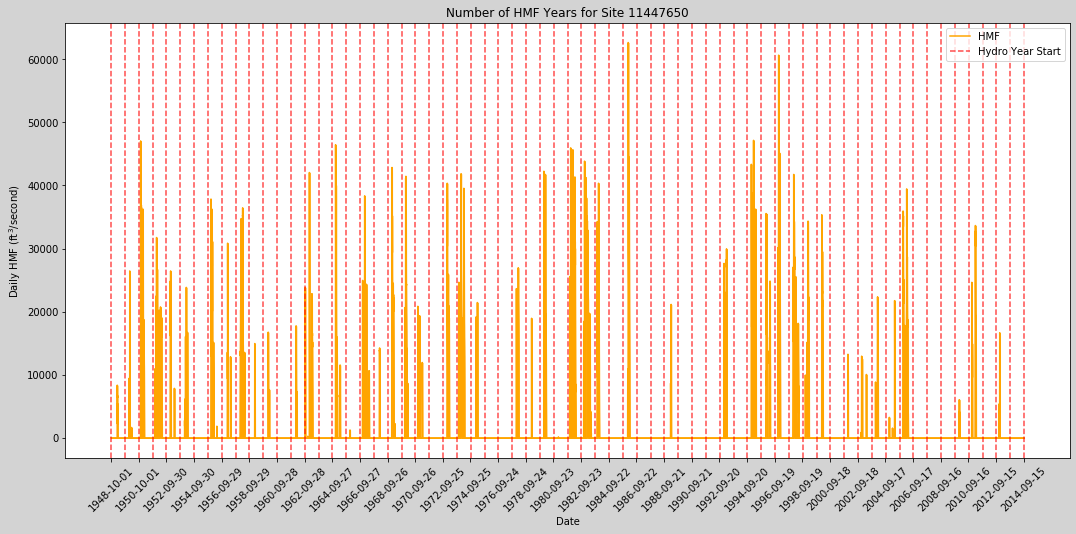

In [92]:
def num_years(df: pd.DataFrame):
    """Returns the integer number of years"""
#     df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])
#     df.set_index('datetime', inplace=True)    
#     #df.loc[:, 'offsetdate'] = (df.index - pd.offsets.YearBegin(month=offset))    
#     return df['year'].dt.year.nunique()
    df['year'] = df['datetime'].dt.year
    return df['year'].nunique()

df_threshold = df.reset_index()

#start = pd.to_datetime(DEFAULT_END).date() - timedelta(days=365.25 * data_range)
#df_threshold = df_threshold[df_threshold['datetime'].dt.date >= start]
df_threshold = df_threshold.set_index('datetime').tz_localize(None).reset_index()

threshold = calc_threshold(df_threshold, quantile)
hmf_series, _ = filter_hmf(df_threshold, threshold)

hmf_years_full = num_hmf_years(hmf_series, 10)
print(f"HMF Years: {hmf_years_full}")
   
df_copy = df.copy()
df_copy = df_copy.reset_index()
delta = df_copy['datetime'].max().year - df_copy['datetime'].min().year
inter_annual = (hmf_years_full / delta) * 100
print(f"Inter-Annual Frequency: {inter_annual: 0.1f} %")

df_threshold["diff"] = df_threshold["flow_cfs"] - threshold
df_threshold["hmf"] = df_threshold["diff"].apply(lambda x: max(0, x))

plt.figure(figsize=(18, 8), facecolor='lightgray')
plt.plot(df_threshold["datetime"], df_threshold["hmf"], label="HMF", color="orange")

df_threshold["datetime"] = pd.to_datetime(df_threshold["datetime"], errors='coerce')

first = True
for year in range(df_threshold["datetime"].dt.year.min(), df_threshold["datetime"].dt.year.max() + 1):
    oct1 = pd.to_datetime(f'{year}-10-01')

    if first:
        plt.axvline(oct1, color='red', linestyle='--', alpha=0.7, label='Hydro Year Start')
        first = False
    else:
        plt.axvline(oct1, color='red', linestyle='--', alpha=0.7)        

plt.fill_between(df_threshold["datetime"], df_threshold["hmf"], color="orange")

plt.xticks(df_threshold['datetime'][::(365*2)], rotation=45)
plt.xlabel("Date")

plt.ylabel('Daily HMF ($\mathregular{ft^3}$/second)')

plt.title(f"Number of HMF Years for Site {site_id}")
plt.legend()
plt.show()

In [94]:
# KO Inter-annual frequency
def add_WY_DOHY(df):
    #df['datetime'] = pd.to_datetime(df.index)
    #df.index = df.index.date # reset index to date only (no time)
    df['month'] = df['datetime'].dt.strftime('%m') # create month column
    df['year'] = df['datetime'].dt.strftime('%Y') # create year column 
    df['WY'] = np.where((df['month'] == '10') | (df['month'] == '11') | (df['month'] == '12'), df['year'].astype(int) + 1, df['year'].astype(int)) # create WY column where the WY resets in Oct
    df['WY'] = df['WY'].values.astype(str)
    df['DOY'] = df['datetime'].dt.dayofyear # create column with DOY
    df['DOHY'] = [d - 273 if d >= 274 else d + 91 for d in df['DOY']]
    #df.set_index('datetime', inplace=True)
    columns_to_remove = ['month', 'year']
    df = df.drop(columns=columns_to_remove)
    return df

def calc_inter_ann_fre(df):  
    df.set_index('datetime', inplace=True)
    hmf_years = df.loc[df['flow_cfs'] != 0].WY.unique() # list of WYs with HMFs
    all_years = df.WY.unique() # list of all WYs
    hmf_years_list = [1 if year in hmf_years.tolist() else 0 for year in all_years] # list of 0 or 1 for WY without and with HMF
    inter_ann_frequ = round(len(hmf_years) / len(all_years) * 100, 1)
    return hmf_years, inter_ann_frequ # returns value

# Calculate the hmf df
df_threshold = df.reset_index()
df_threshold = df_threshold.set_index('datetime').tz_localize(None).reset_index()
hmf_df = calc_hmf(df_threshold, threshold)
hmf_df = add_WY_DOHY(hmf_df)

# Calculate the average annual magntiude of high flows 
hmf_years, inter_ann_fre = calc_inter_ann_fre(hmf_df)

print(f"HMF Years: {len(hmf_years)}")
print(f"Average Annual HMF Duration: {inter_ann_fre:.2f} %")

HMF Years: 47
Average Annual HMF Duration: 71.20 %


## Metric: Timing

In [57]:
def calc_timing(df: pd.DataFrame):
    """Calculates the average numerical day per hydrologic year that HMF reaches the center of mass threshold"""
    df = df.reset_index()
    
    df['datetime'] = df['datetime'] + pd.DateOffset(months=-9)
    
    df['year'] = df['datetime'].dt.year
    df['day'] = df['datetime'].dt.dayofyear
    df['cumsum'] = df.groupby('year')['flow_cfs'].cumsum()
    df['t_sum'] = df.groupby('year')['flow_cfs'].transform('sum')
    print(df)

    com_series = df[df['cumsum'] >= df['t_sum'] / 2].groupby('year')['day'].first()
    print(com_series)
    timing = com_series.mean()    

    return timing
    

#df_threshold = df.reset_index()
df_threshold = df_threshold.set_index('datetime').tz_localize(None).reset_index()
threshold = calc_threshold(df_threshold, quantile)
hmf_series, _ = filter_hmf(df_threshold, threshold)

center_of_mass = calc_timing(hmf_series)
center_of_mass

      index   datetime  flow_cfs 00060_Mean_cd   site_no  hmf_cfs  year  day  \
0       496 1931-05-09   12700.0             A  11303500    900.0  1931  129   
1       497 1931-05-10   14600.0             A  11303500   2800.0  1931  130   
2       498 1931-05-11   15600.0             A  11303500   3800.0  1931  131   
3       499 1931-05-12   15900.0             A  11303500   4100.0  1931  132   
4       500 1931-05-13   16100.0             A  11303500   4300.0  1931  133   
...     ...        ...       ...           ...       ...      ...   ...  ...   
3063  29446 2010-08-15   12100.0             A  11303500    300.0  2010  227   
3064  29447 2010-08-16   11900.0             A  11303500    100.0  2010  228   
3065  29494 2010-10-02   12700.0             A  11303500    900.0  2010  275   
3066  29495 2010-10-03   12700.0             A  11303500    900.0  2010  276   
3067  29496 2010-10-04   12000.0             A  11303500    200.0  2010  277   

         cumsum      t_sum  
0       12

184.87179487179486

        datetime  flow_cfs 00060_Mean_cd   site_no  hmf_cfs
0     1930-10-01       0.0             A  11303500      0.0
1     1930-10-02       0.0             A  11303500      0.0
2     1930-10-03       0.0             A  11303500      0.0
3     1930-10-04       0.0             A  11303500      0.0
4     1930-10-05       0.0             A  11303500      0.0
...          ...       ...           ...       ...      ...
30676 2014-09-26       0.0          A, e  11303500      0.0
30677 2014-09-27       0.0          A, e  11303500      0.0
30678 2014-09-28       0.0          A, e  11303500      0.0
30679 2014-09-29       0.0          A, e  11303500      0.0
30680 2014-09-30       0.0          A, e  11303500      0.0

[30681 rows x 5 columns]


C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


datetime
1930-10-01      0.000000
1931-10-01    226.979981
1932-10-01      0.000000
1933-10-01      0.000000
1934-10-01    227.627891
                 ...    
2009-10-01      0.000000
2010-10-01    188.187118
2011-10-01      0.000000
2012-10-01      0.000000
2013-10-01      0.000000
Freq: AS-OCT, Name: hmf_cfs, Length: 84, dtype: float64
Average Annual Timing:  182.9


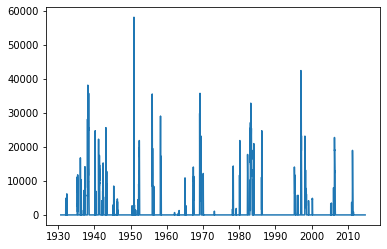

In [56]:
# Timing (center of mass)
def calc_hmf(df, threshold): # HMF = discharge above threshold
    flow_above_threshold_list = [(flow - threshold) if flow > threshold else 0 for flow in df['flow_cfs']]
    df['hmf_cfs'] = flow_above_threshold_list
    return df

def center_of_mass(x):
    num = 0
    den = 0
    for i in range(len(x)):
        num += x[i] * i
        den += x[i]
        #print(x)
    return (num/den)

def calc_tim(df):
    df.set_index('datetime', inplace=True)
    com_list = df['hmf_cfs'].resample('AS-OCT').apply(center_of_mass)
    com_list = com_list.fillna(0)
    return com_list # returns series

df_threshold = df.reset_index()
df_threshold = df_threshold.set_index('datetime').tz_localize(None).reset_index()
threshold = calc_threshold(df_threshold, quantile)
hmf_df = calc_hmf(df_threshold, threshold)

#df_threshold = df.reset_index()
df_threshold = df_threshold.set_index('datetime').tz_localize(None).reset_index()
threshold = calc_threshold(df_threshold, quantile)
hmf_series, zero_deflated_hmf = filter_hmf(df_threshold, threshold)
print(zero_deflated_hmf)
plt.plot(zero_deflated_hmf['datetime'], zero_deflated_hmf['hmf_cfs'])

timing = calc_tim(zero_deflated_hmf)
print(timing)
timing = np.mean(timing[timing != 0])
print(f'Average Annual Timing: {timing: 0.1f}')

## QA/QC: Time Series Plots

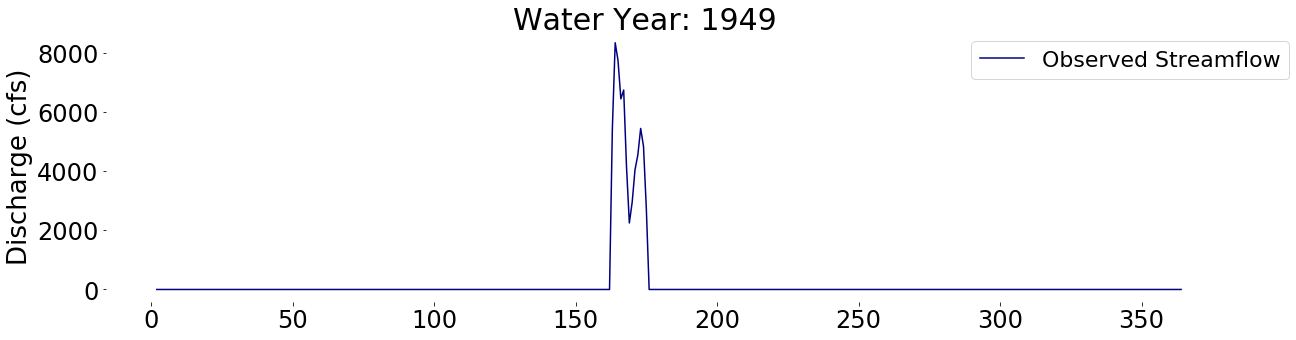

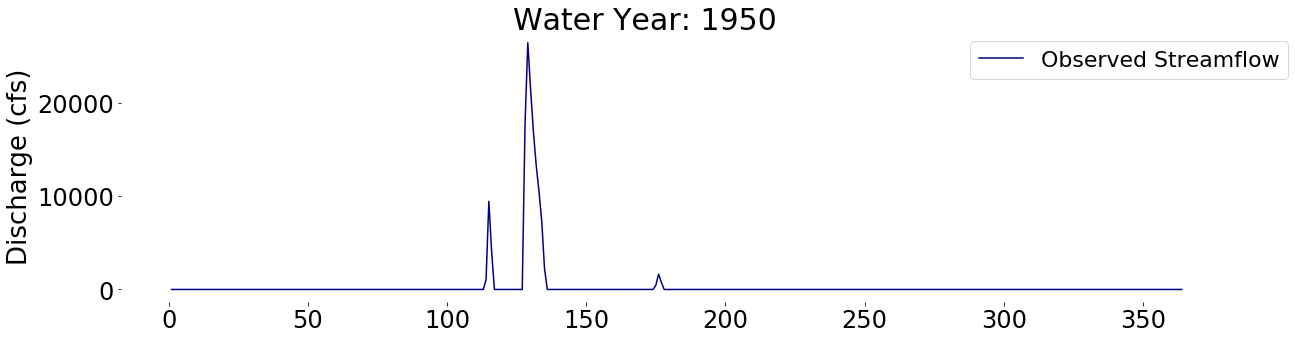

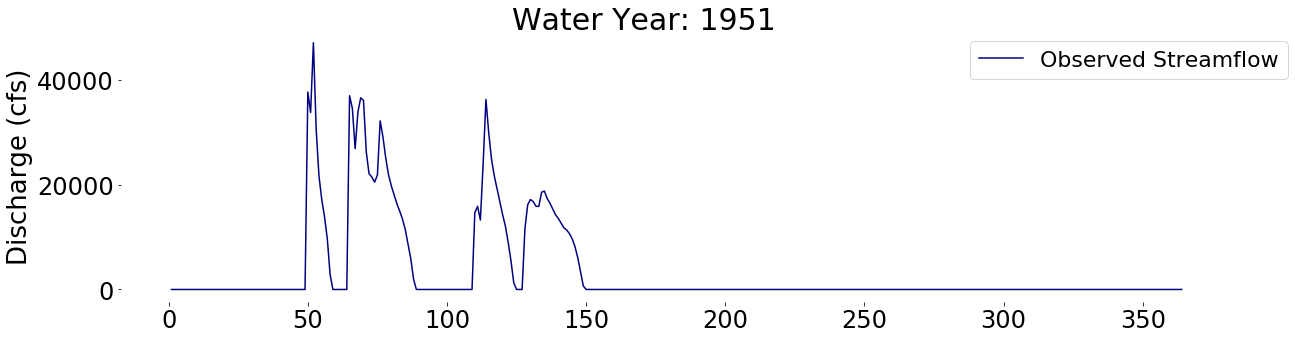

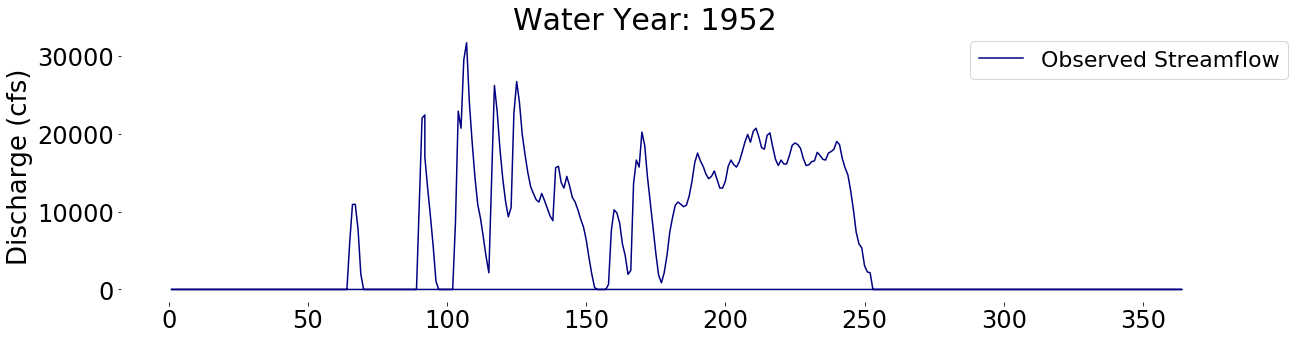

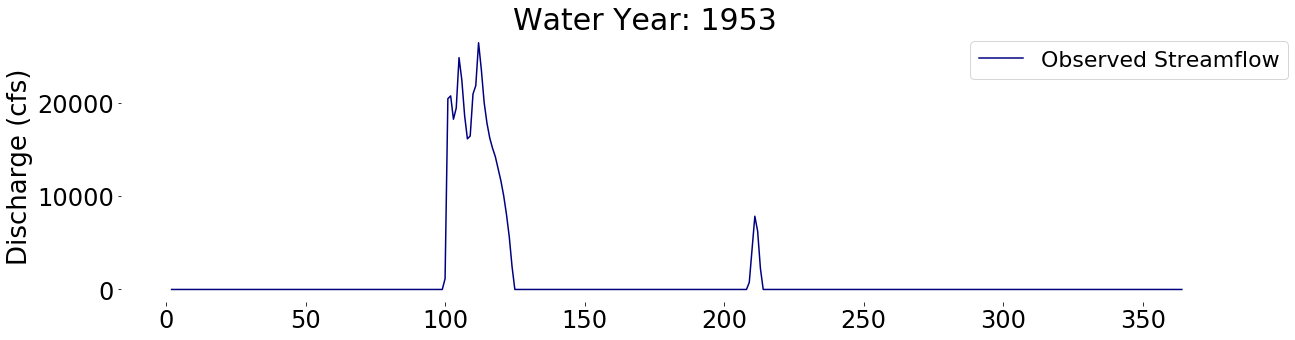

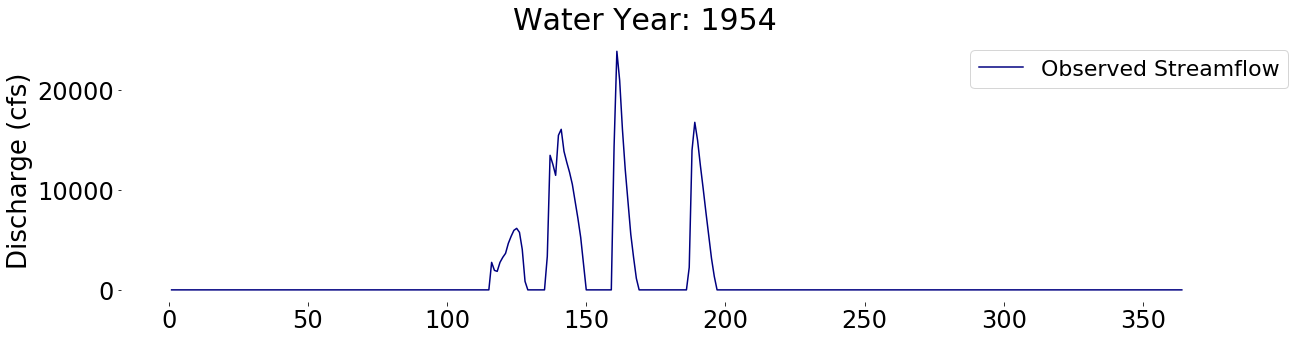

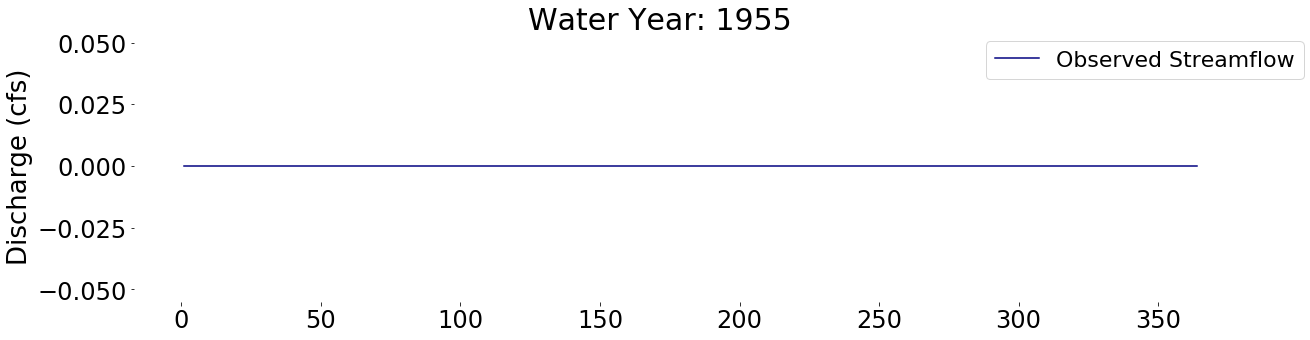

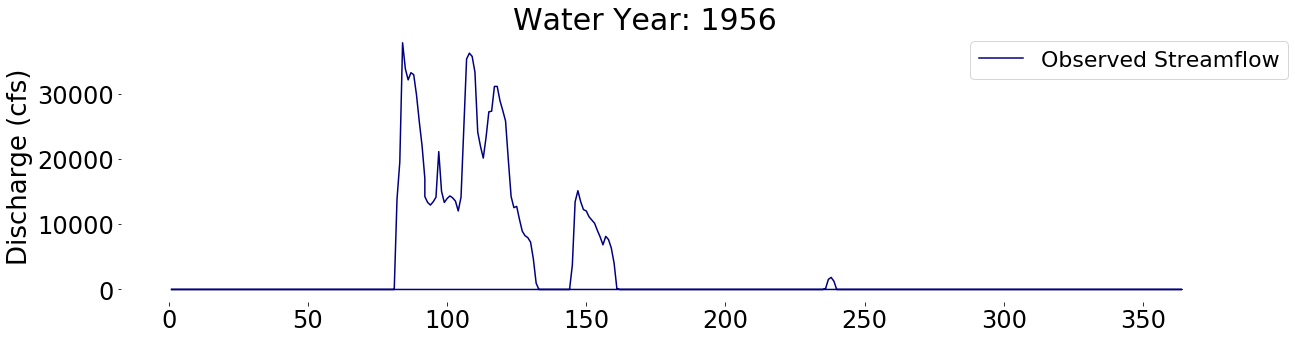

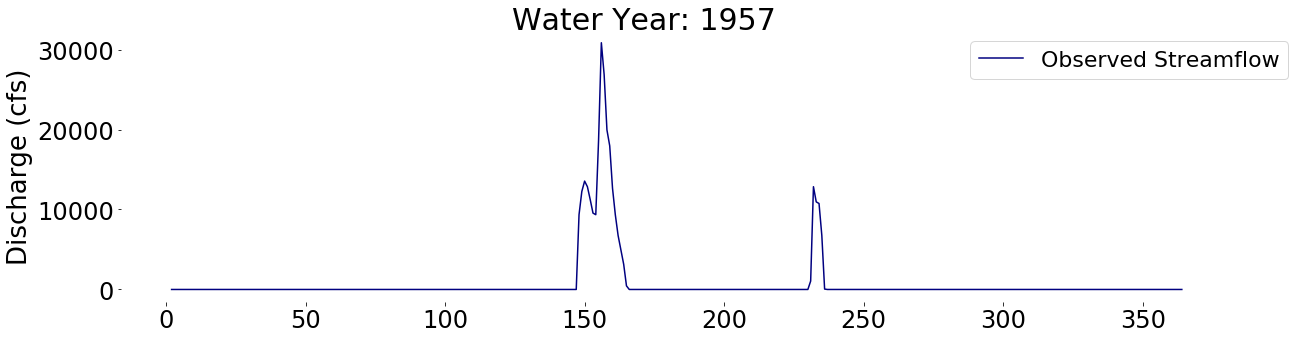

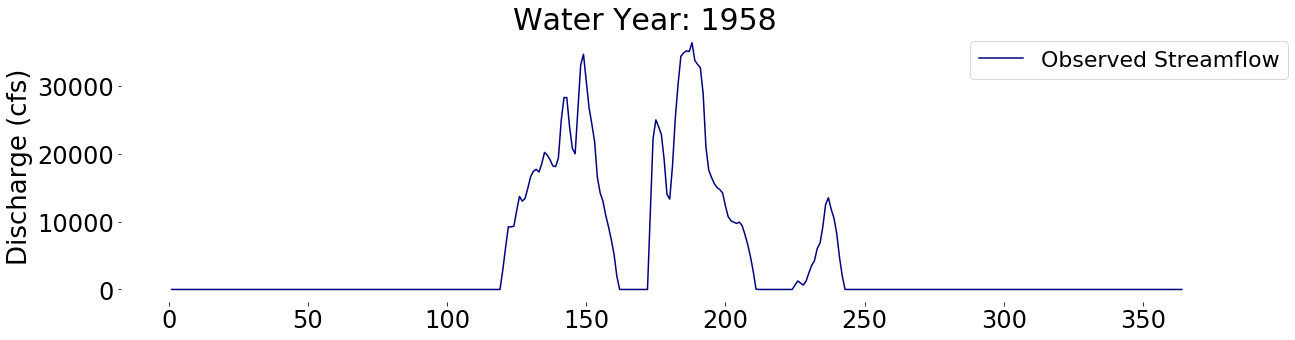

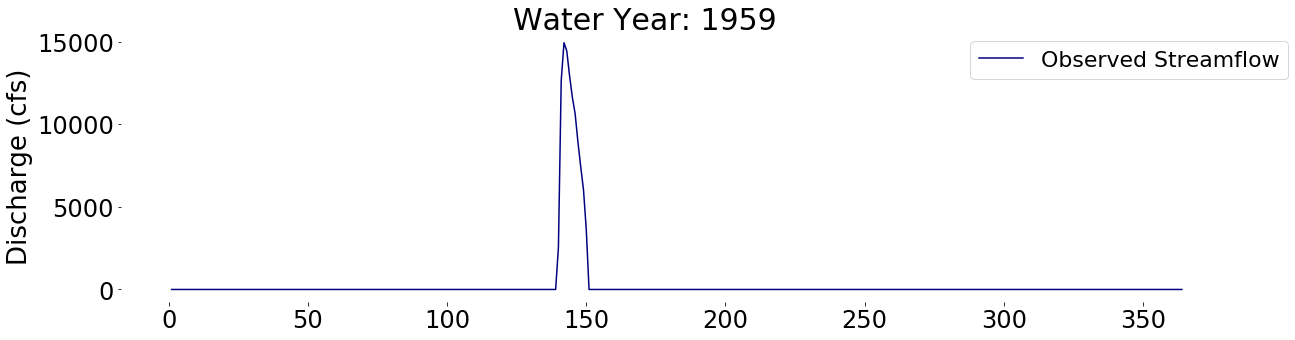

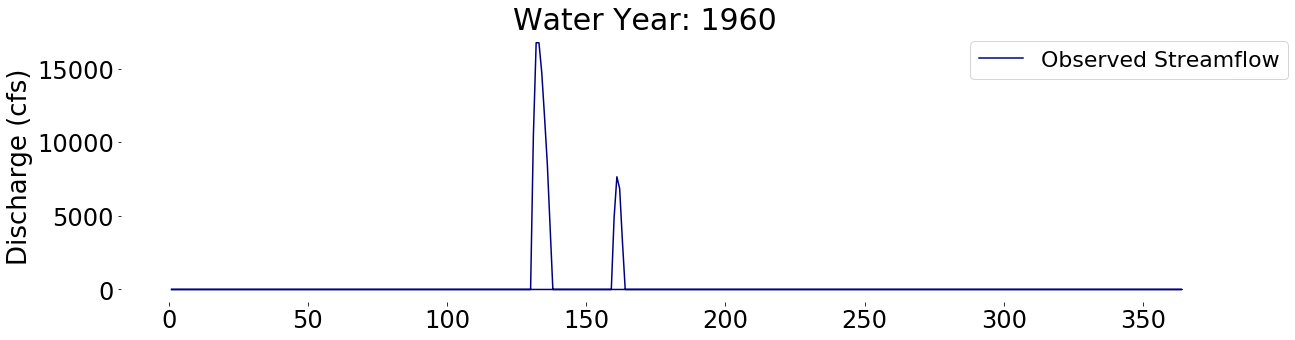

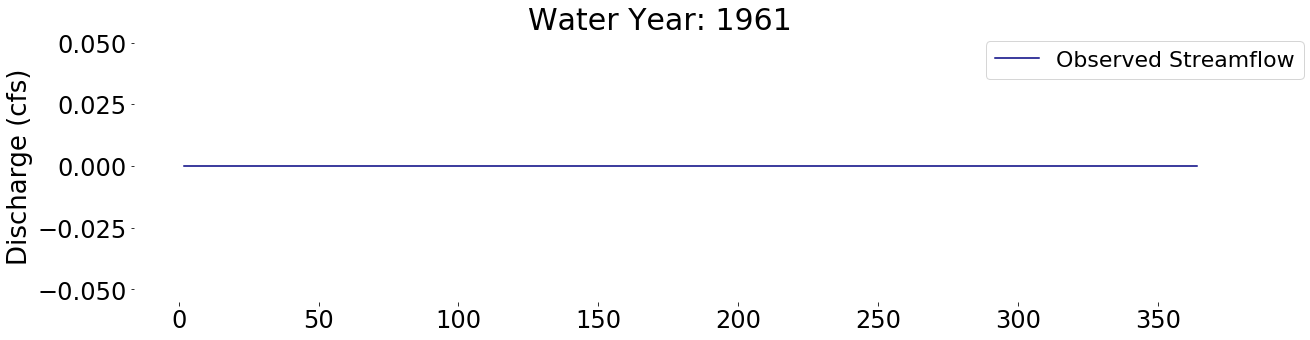

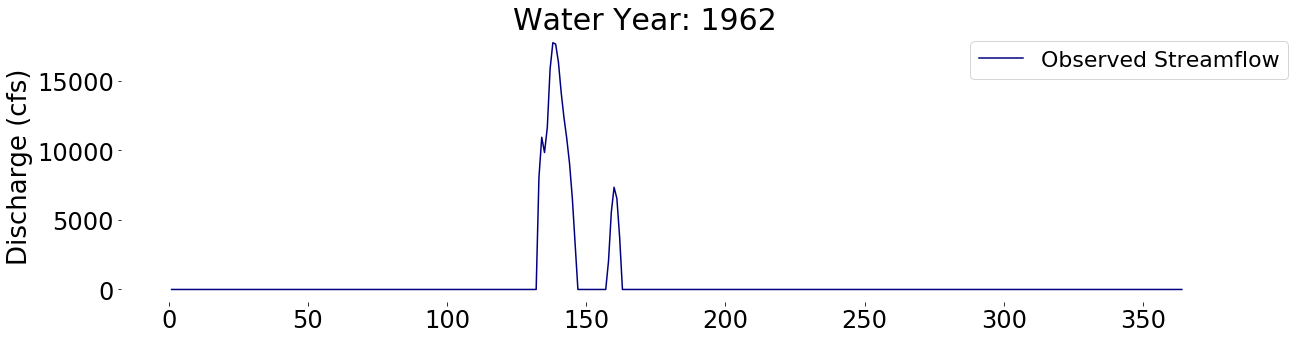

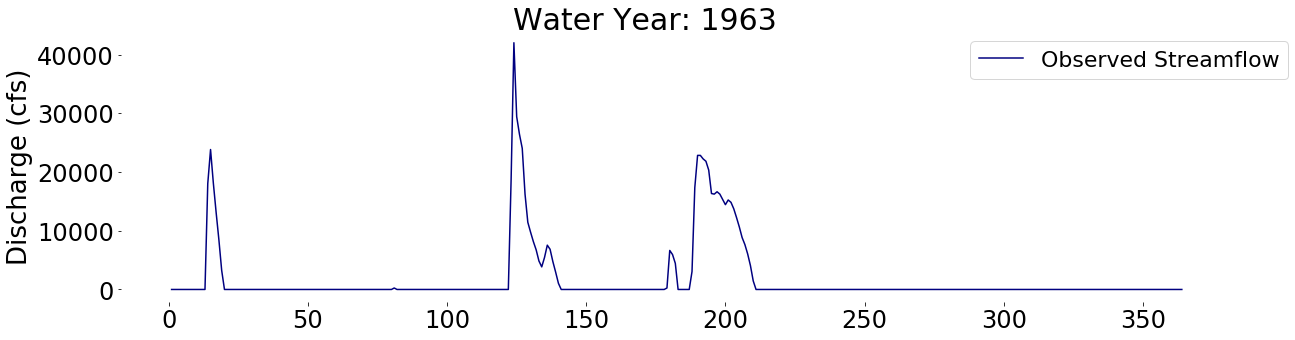

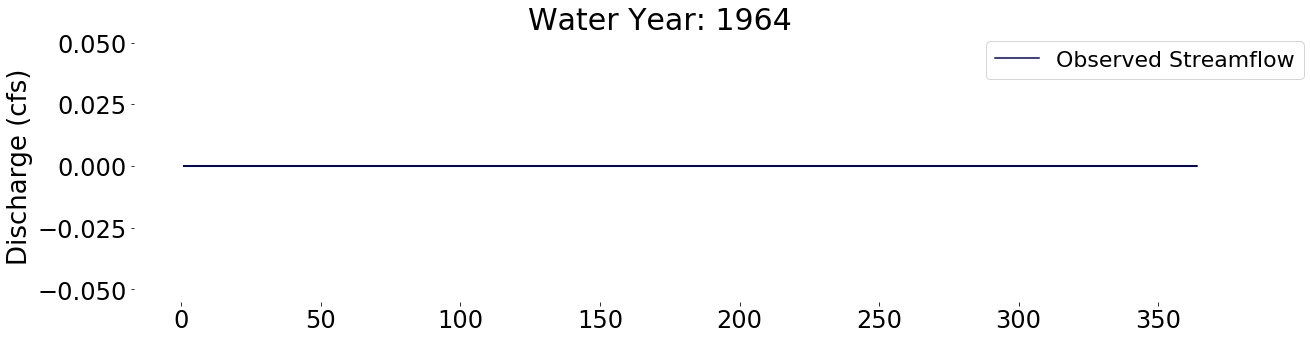

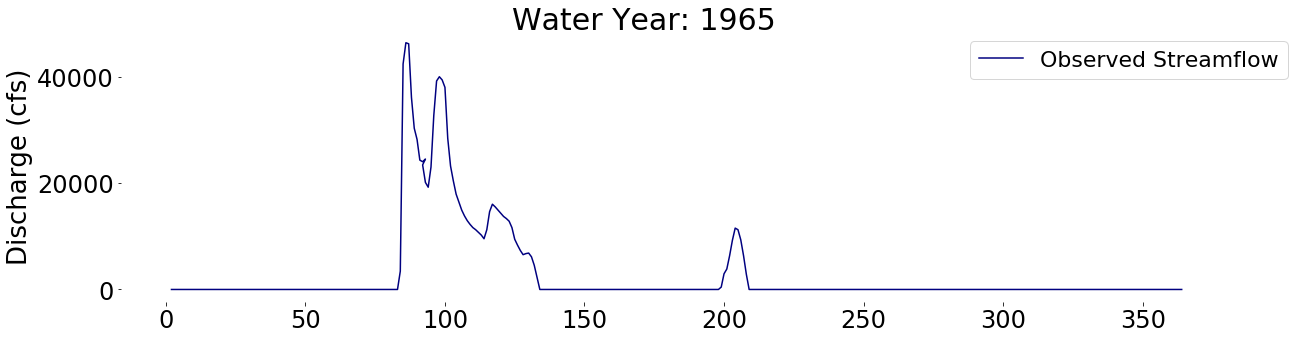

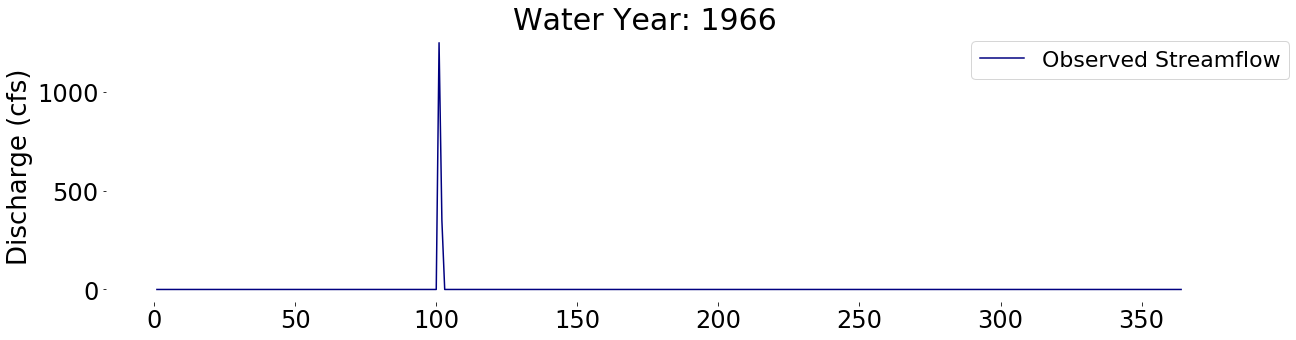

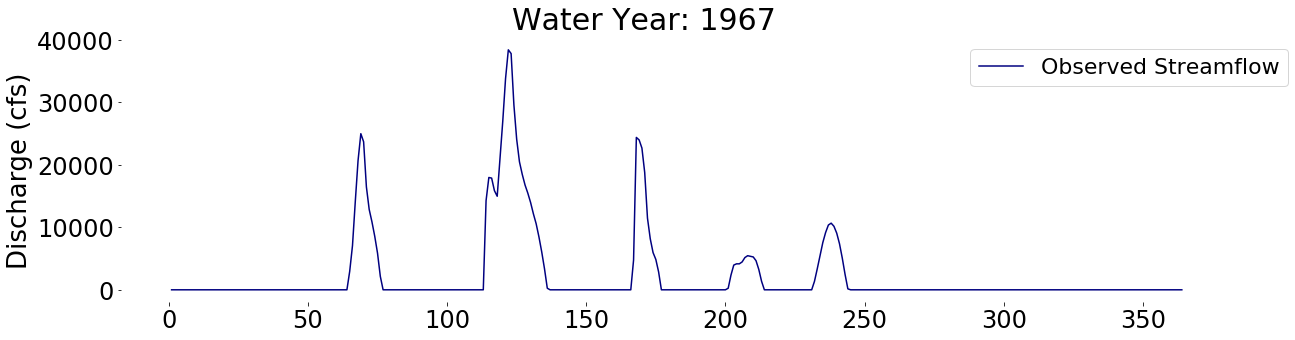

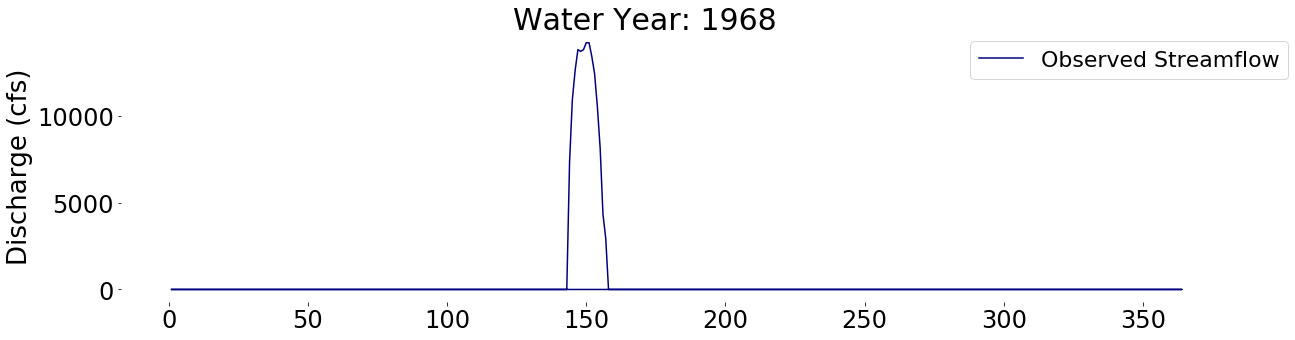

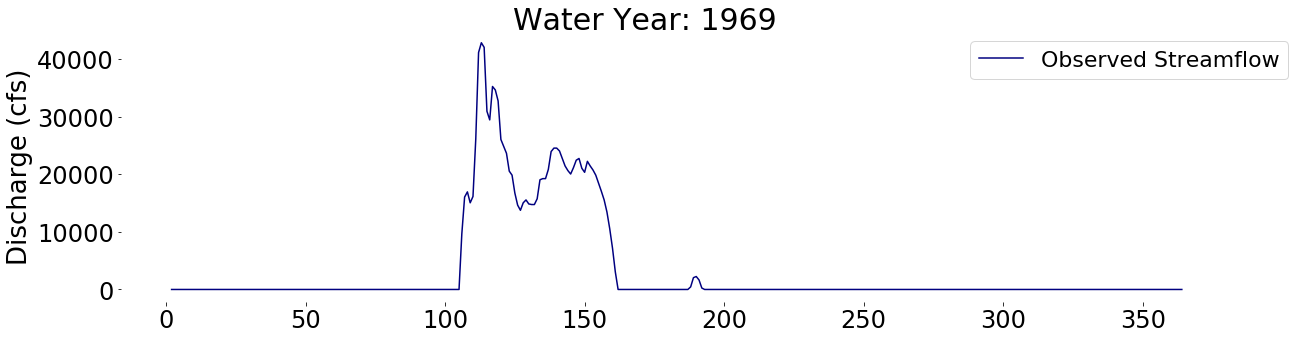

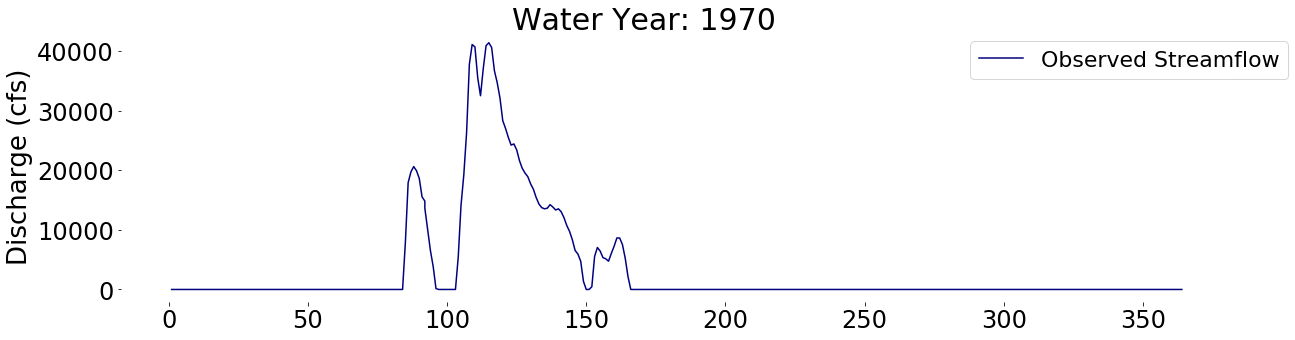

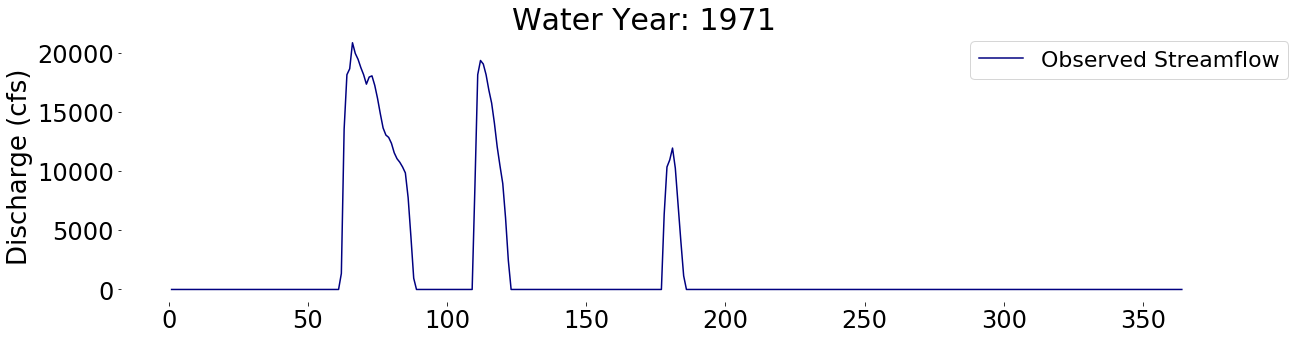

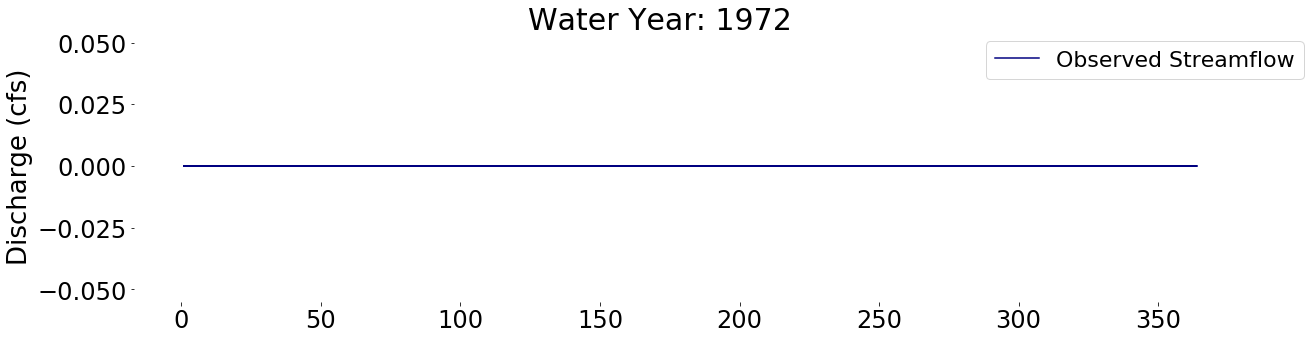

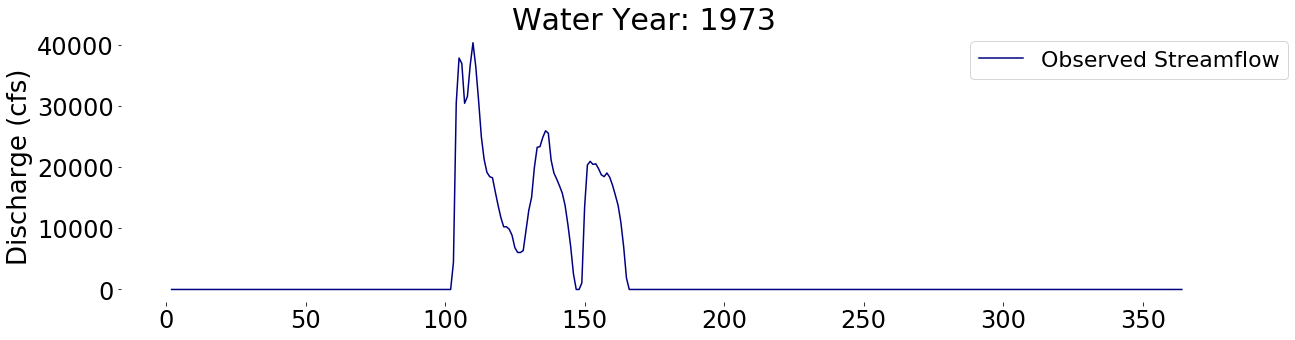

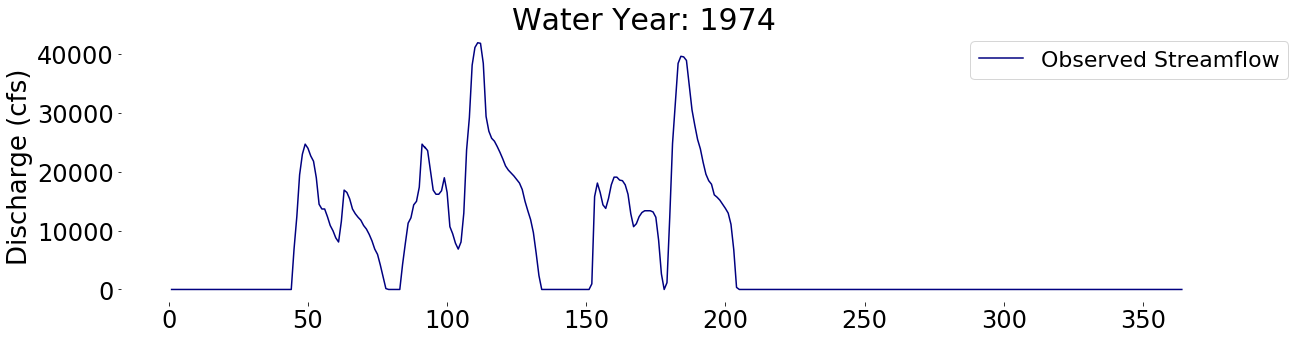

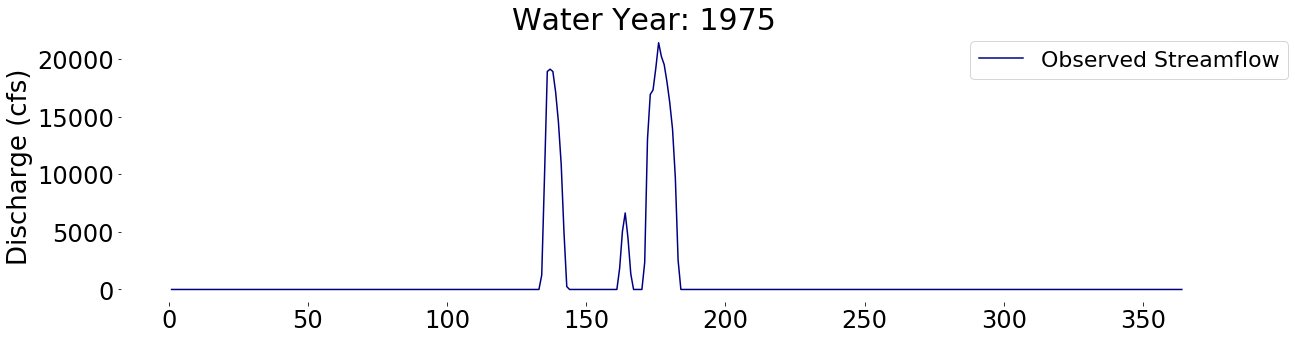

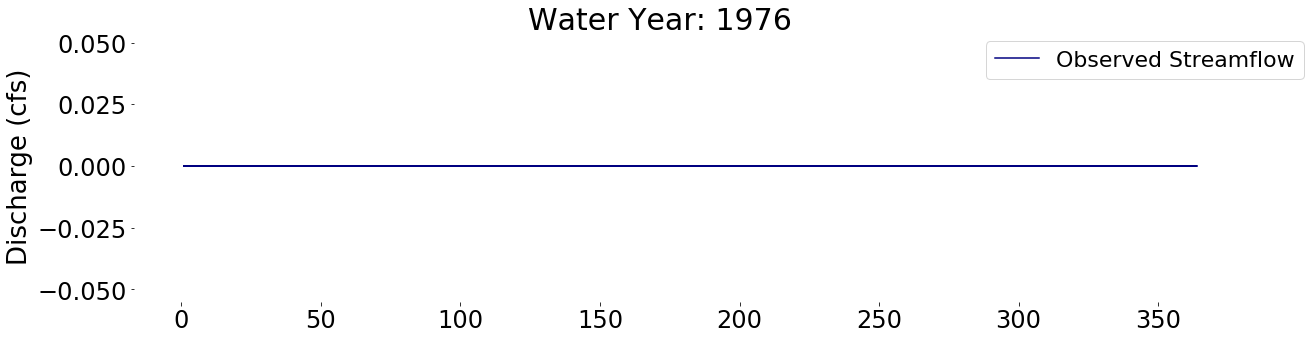

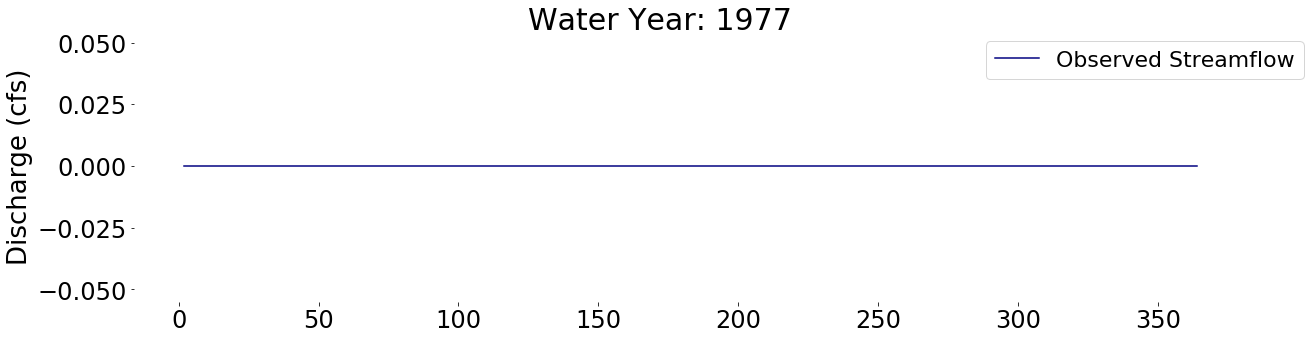

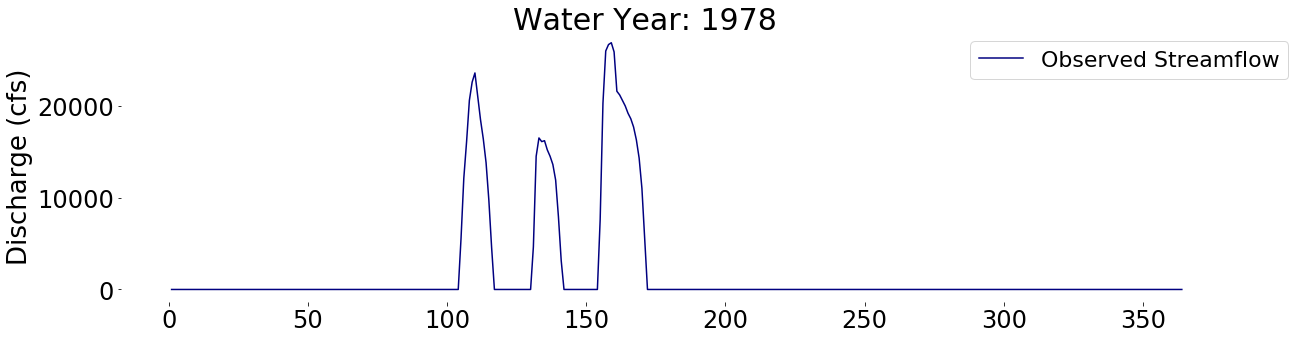

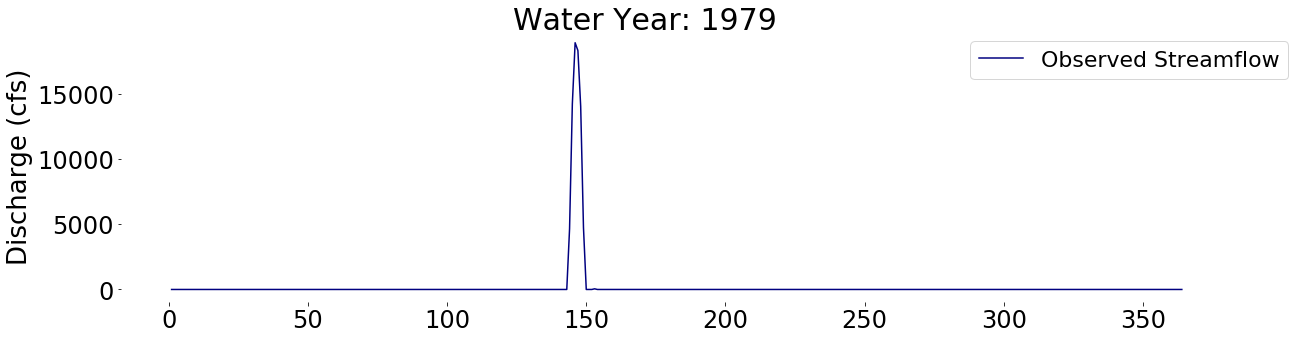

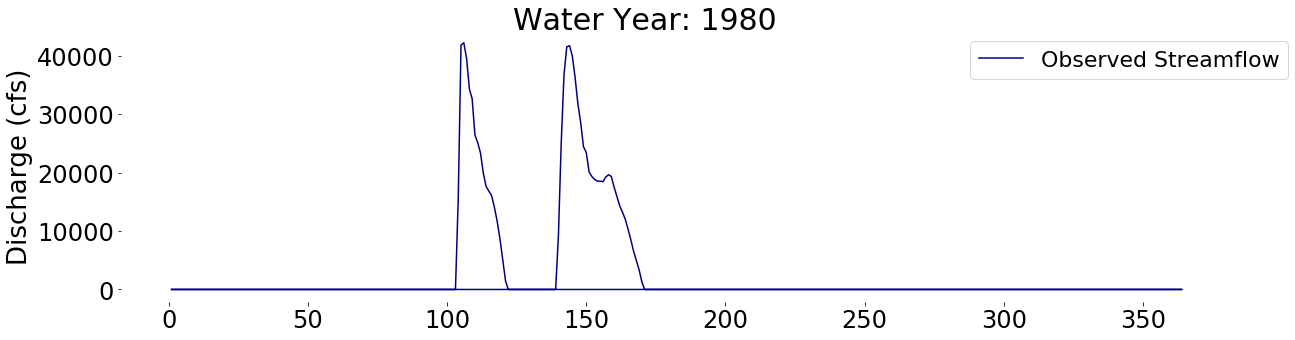

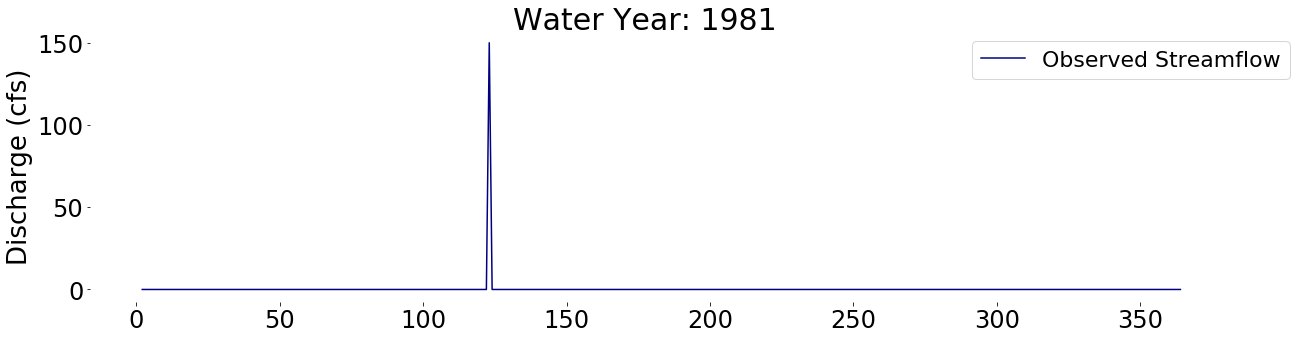

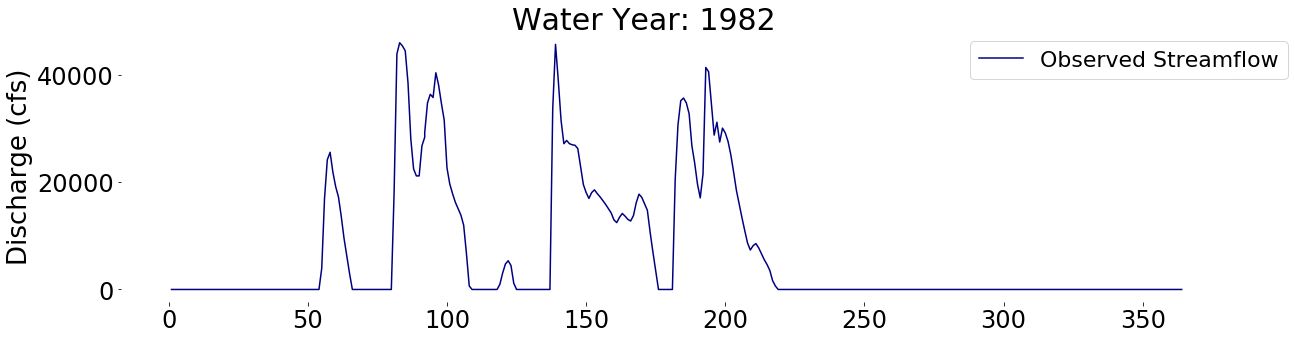

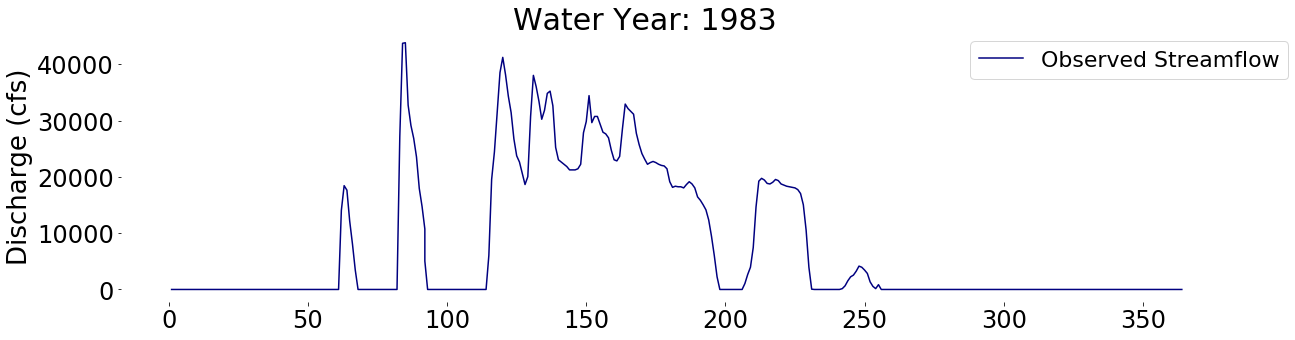

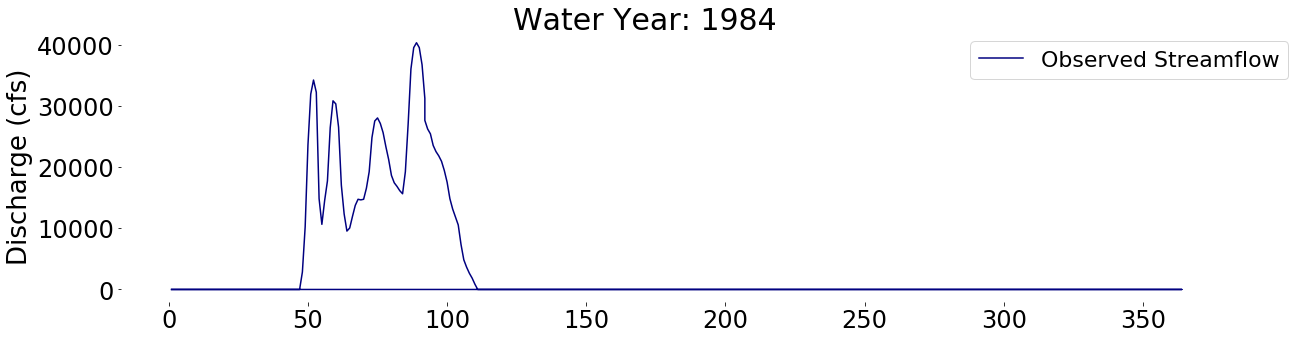

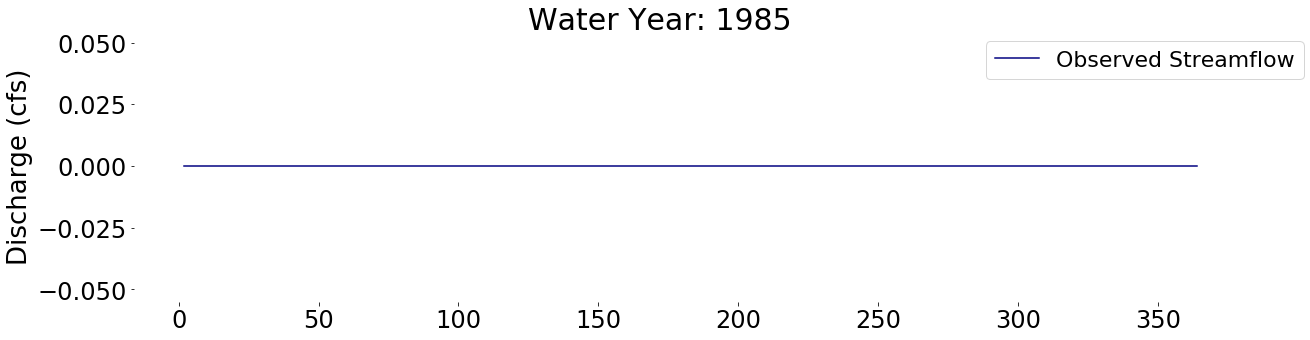

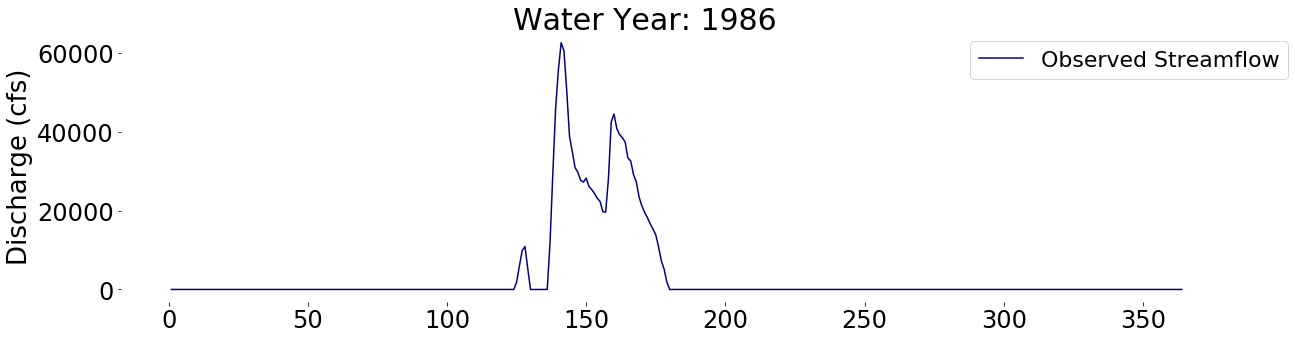

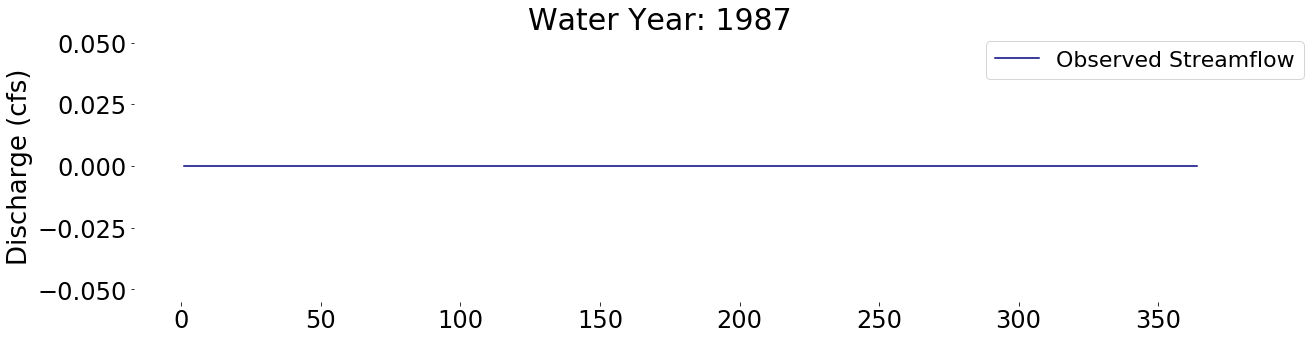

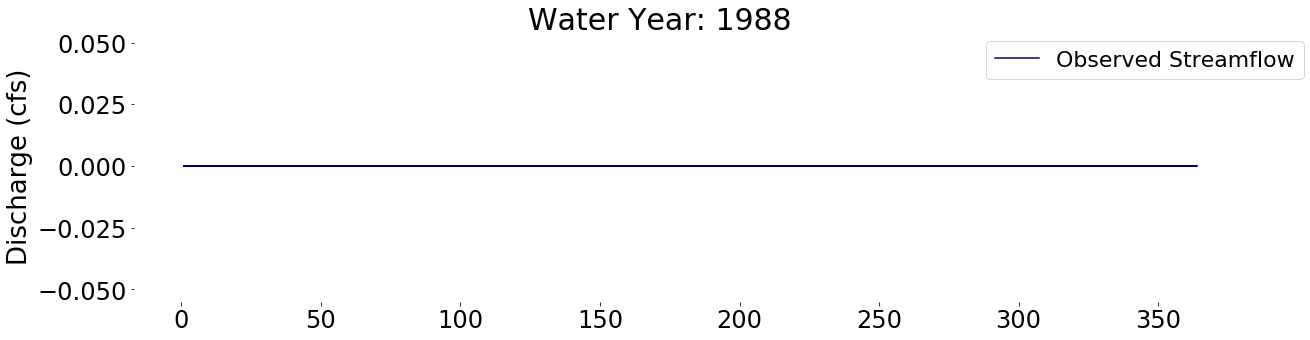

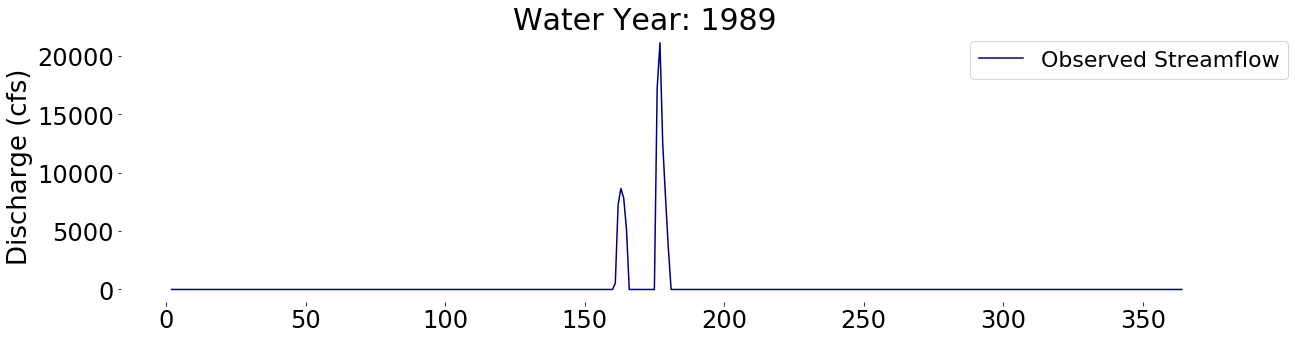

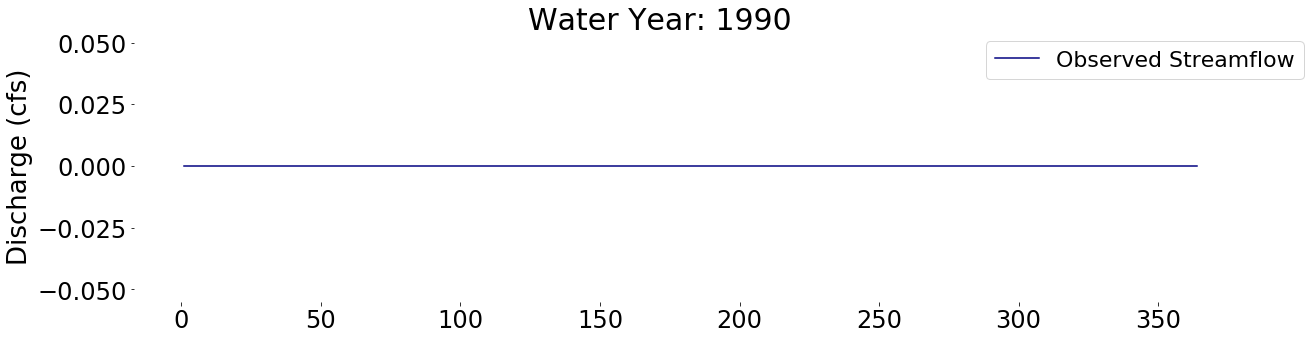

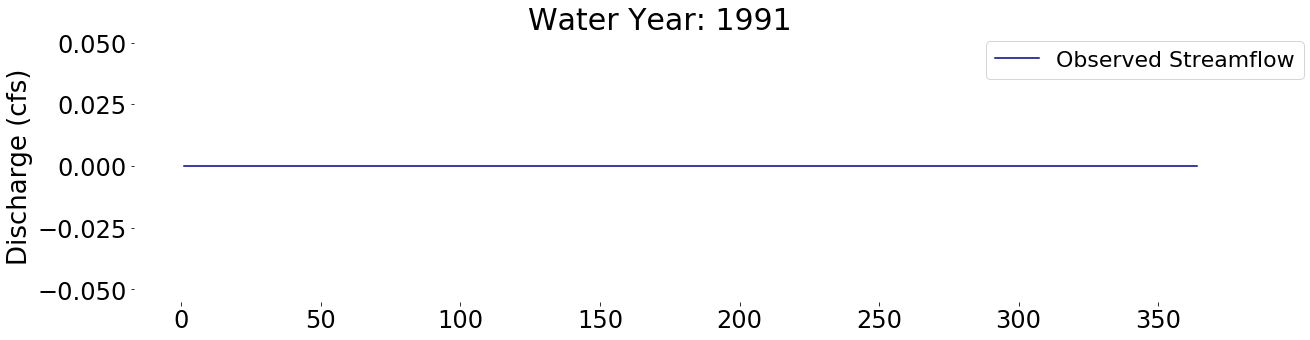

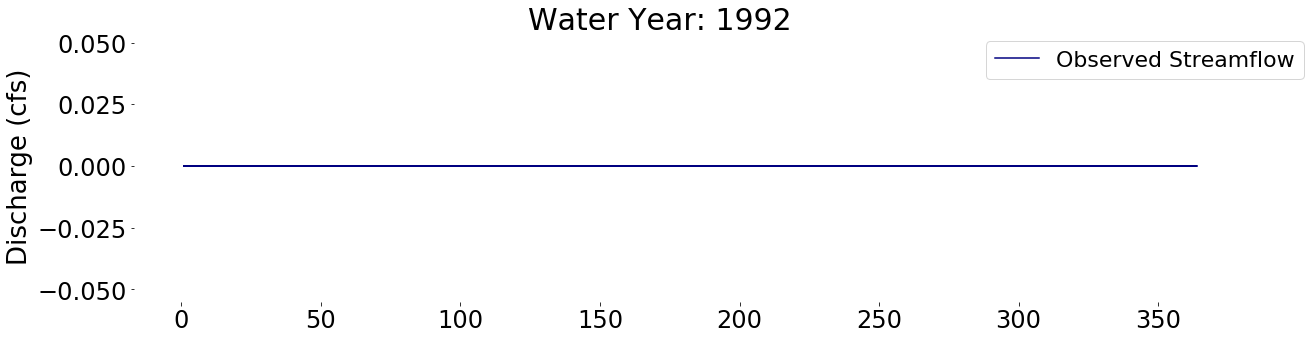

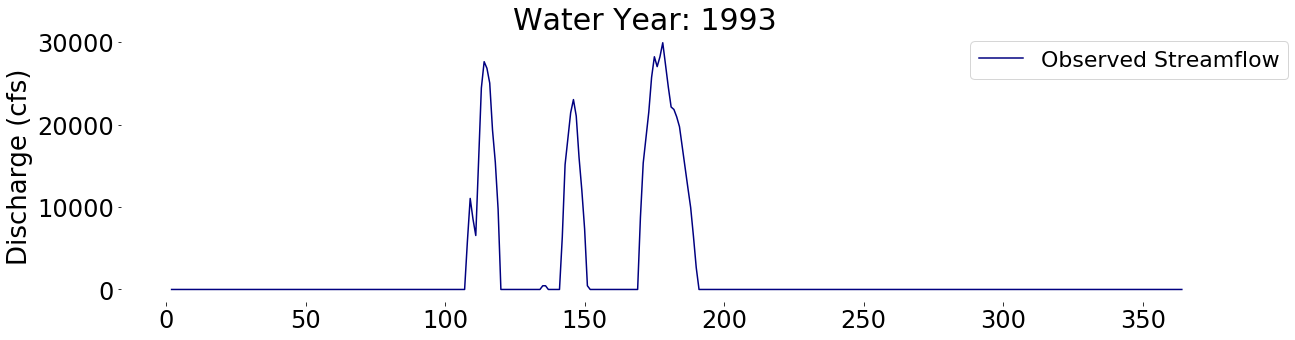

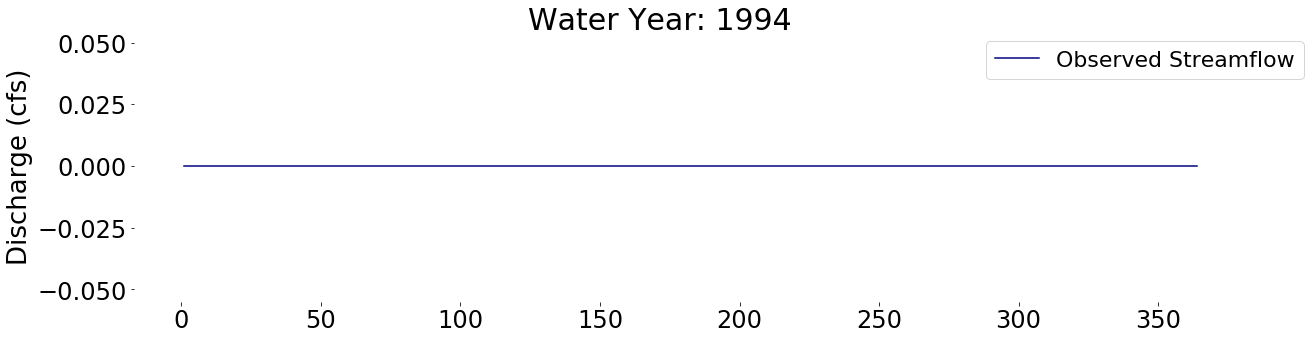

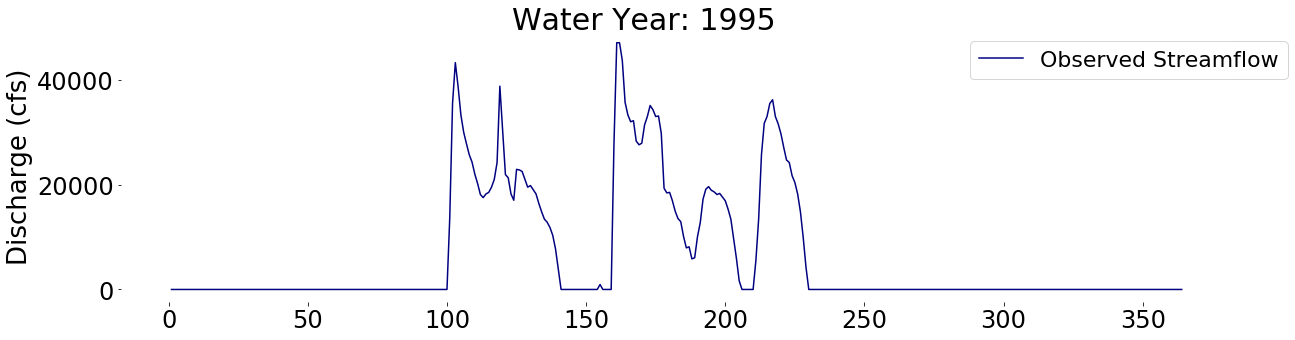

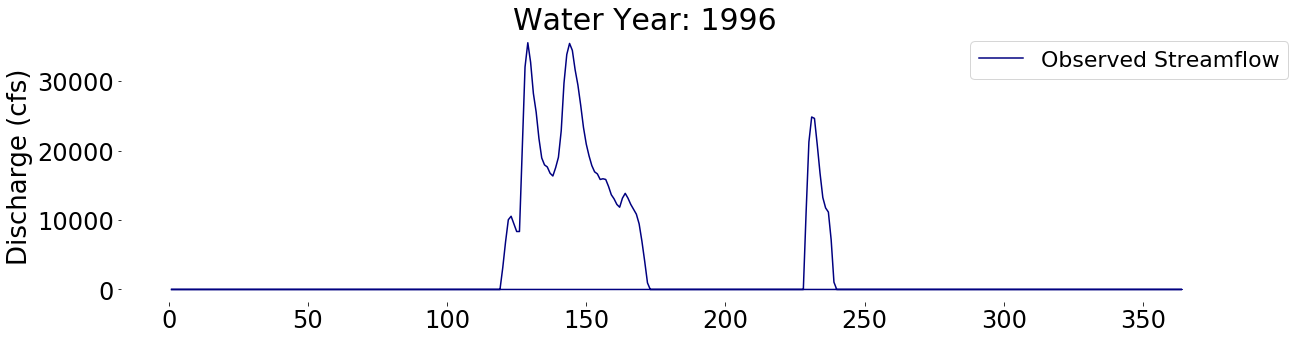

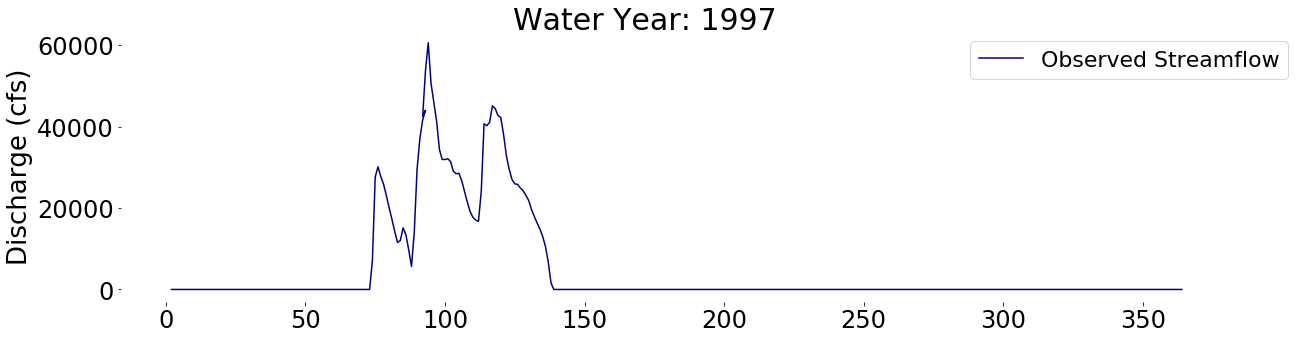

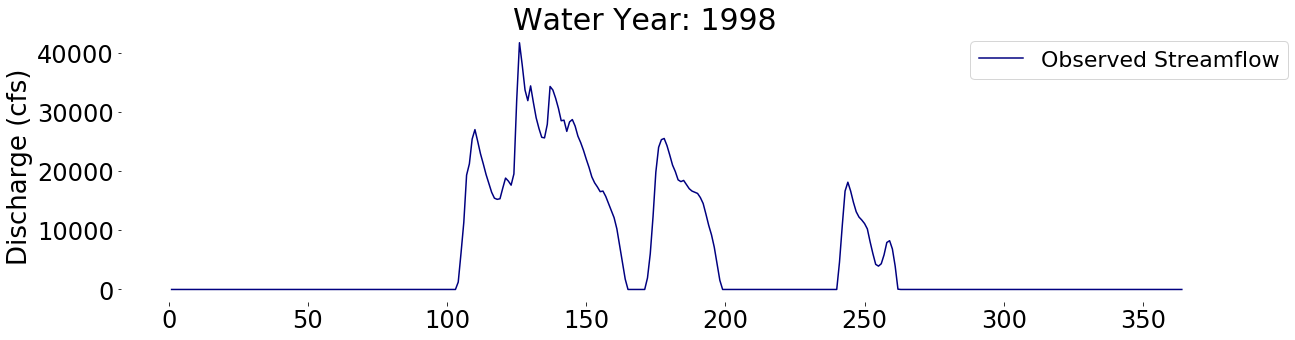

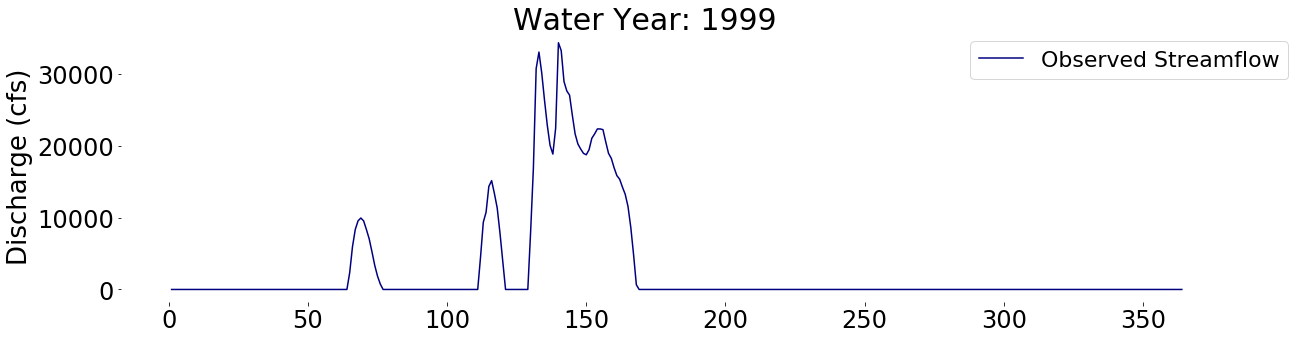

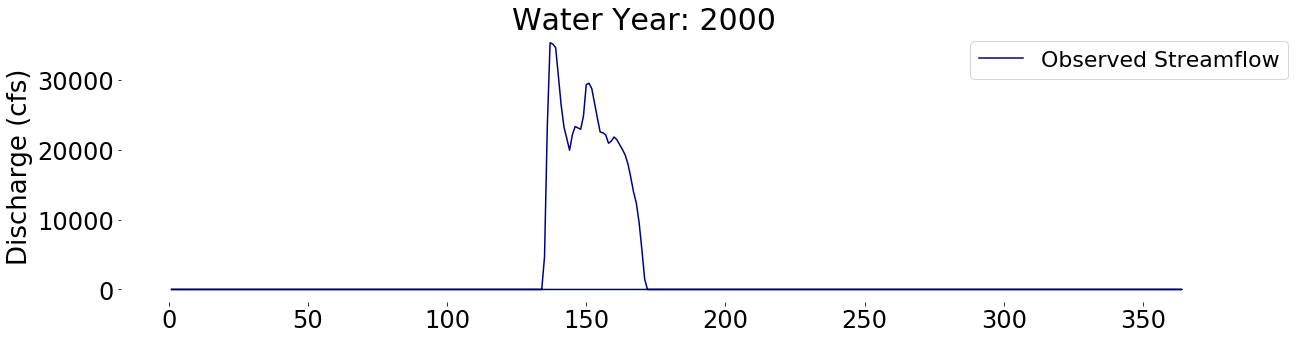

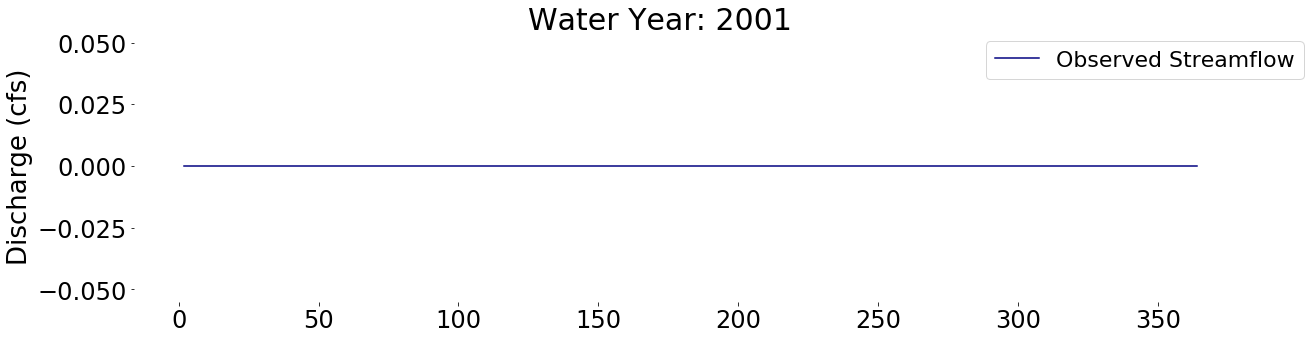

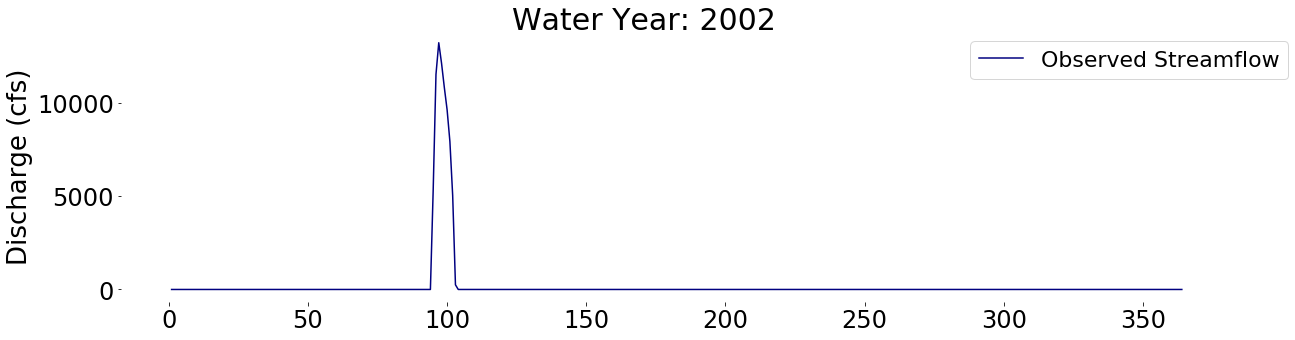

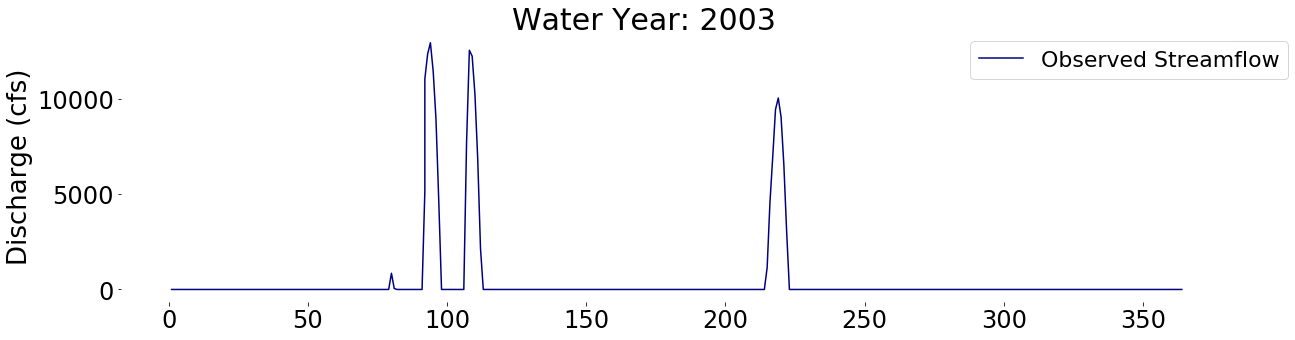

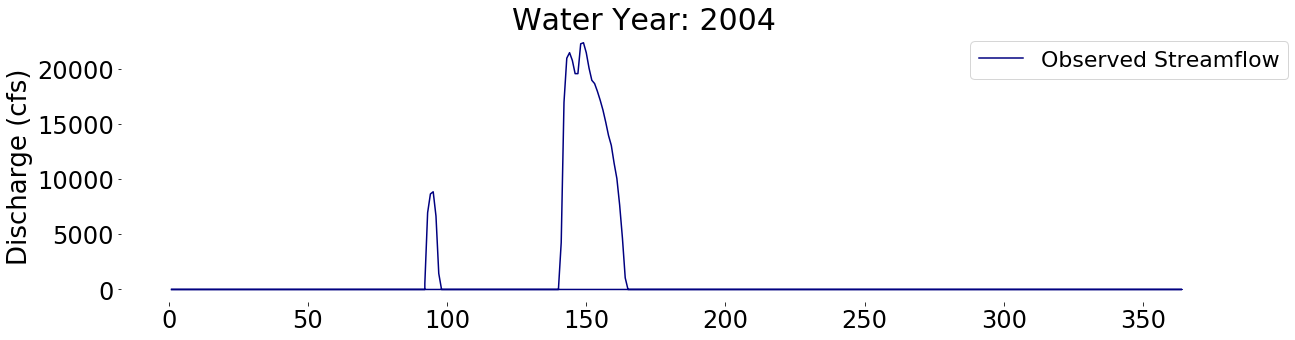

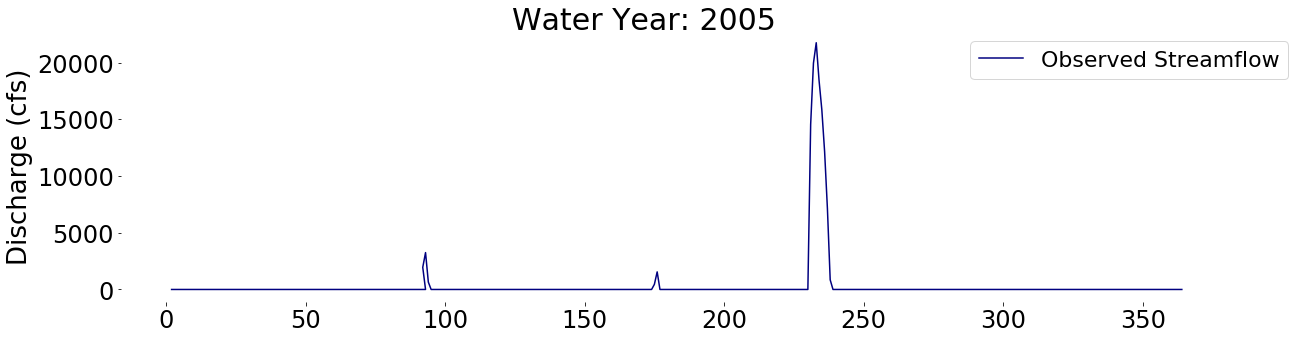

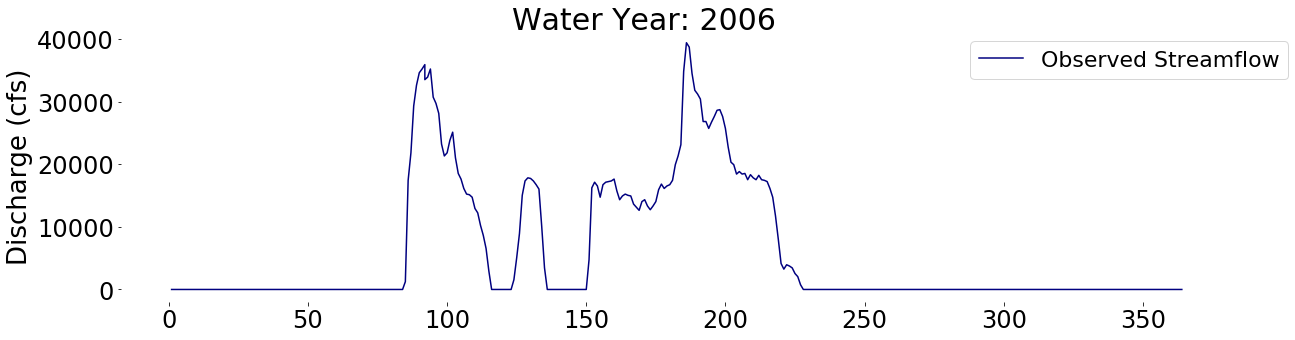

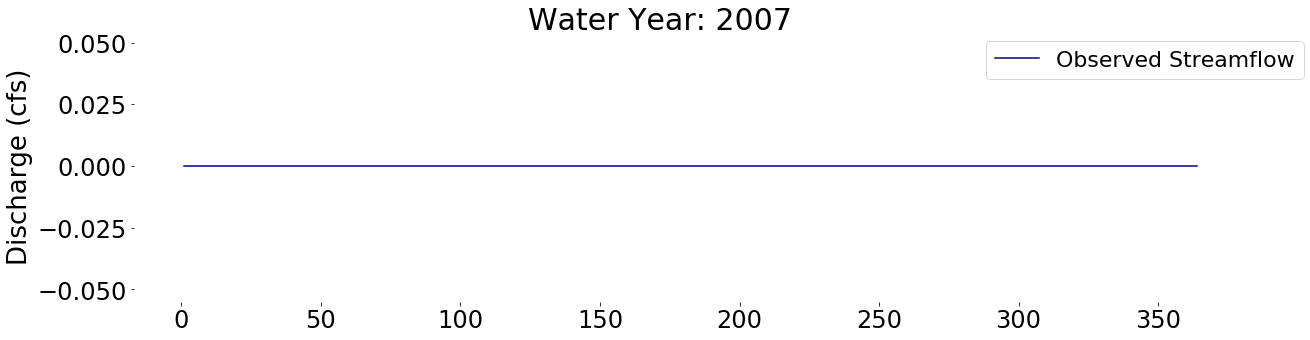

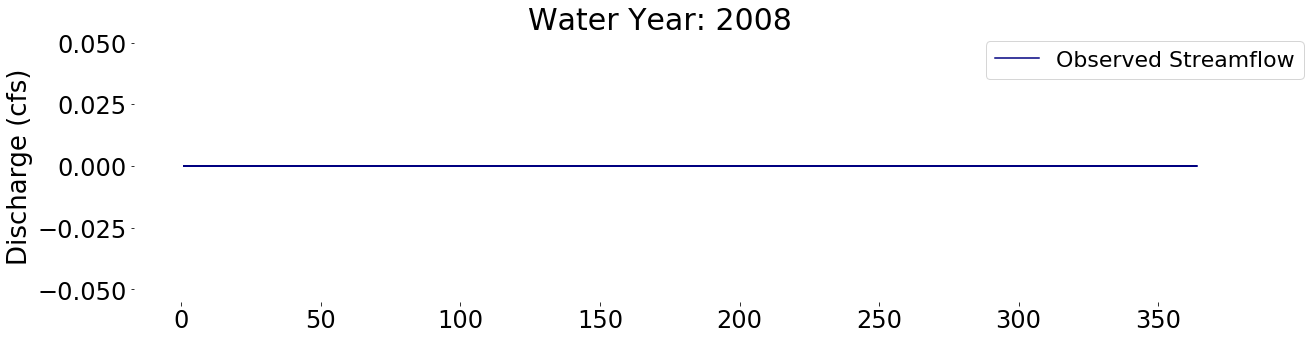

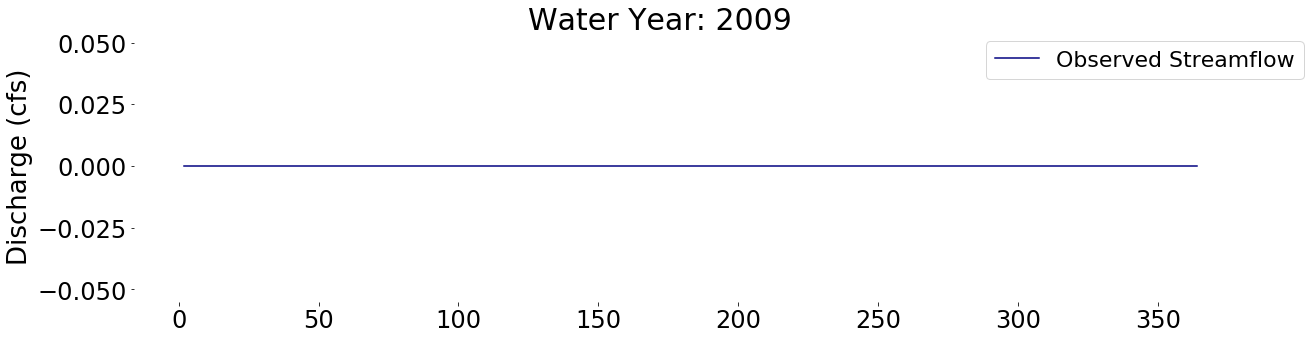

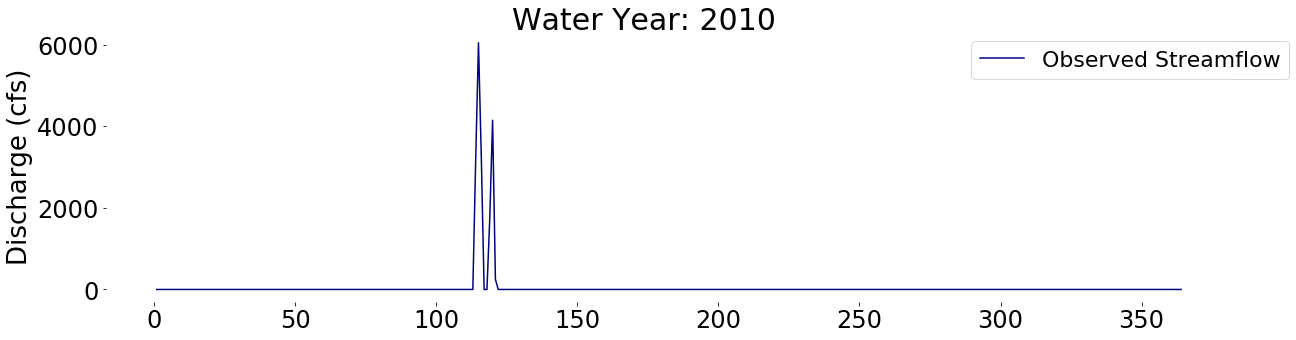

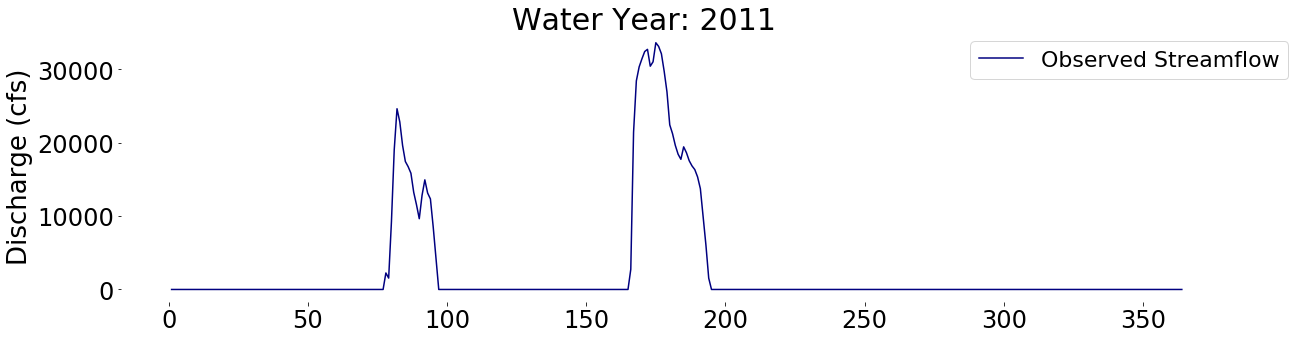

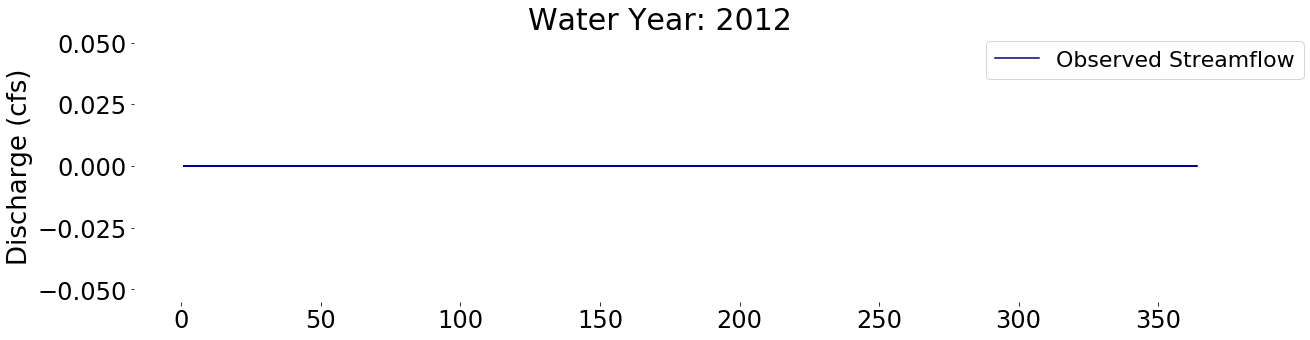

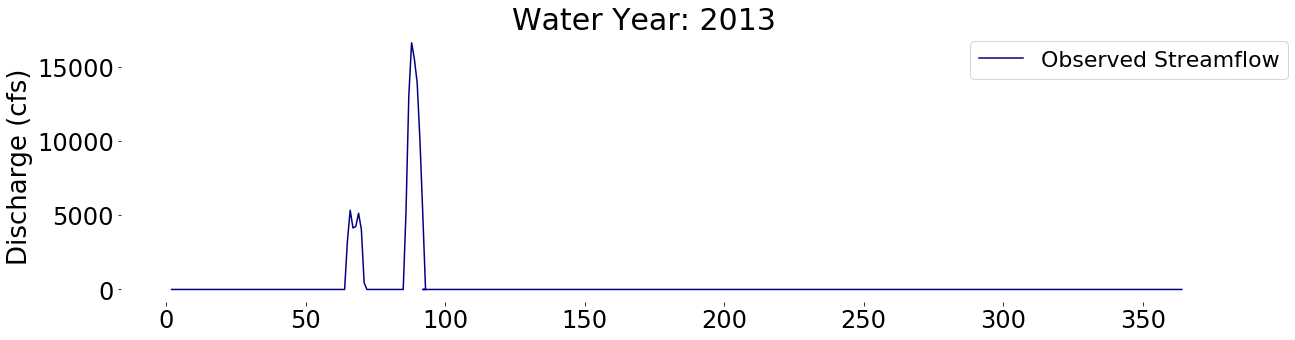

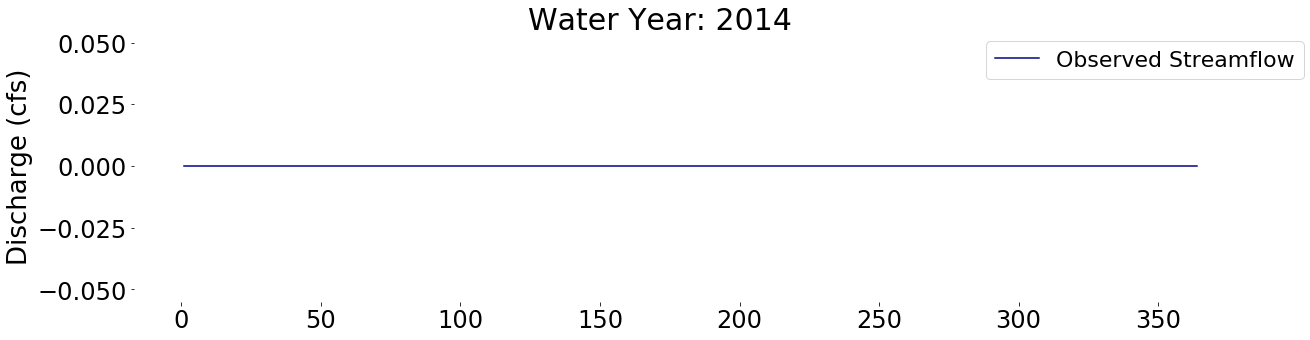

,index,datetime,flow_cfs,00060_Mean_cd,site_no,WY,DOY,DOHY
0,0,1948-10-01,0.0,A,11447650,1949,275,2
1,1,1948-10-02,0.0,A,11447650,1949,276,3
2,2,1948-10-03,0.0,A,11447650,1949,277,4
3,3,1948-10-04,0.0,A,11447650,1949,278,5
4,4,1948-10-05,0.0,A,11447650,1949,279,6
...,...,...,...,...,...,...,...,...
24101,24101,2014-09-26,0.0,A,11447650,2014,269,360
24102,24102,2014-09-27,0.0,A,11447650,2014,270,361
24103,24103,2014-09-28,0.0,A,11447650,2014,271,362
24104,24104,2014-09-29,0.0,A,11447650,2014,272,363


In [90]:
def plot_annual_hydrographs(df: pd.DataFrame):
    df = df.reset_index()
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Group data by year
    #df['year'] = df['datetime'].dt.year
    #df_grouped = df.groupby('year')
    
    df['month'] = df['datetime'].dt.strftime('%m') # create month column
    df['year'] = df['datetime'].dt.strftime('%Y') # create year column 
    df['WY'] = np.where((df['month'] == '10') | (df['month'] == '11') | (df['month'] == '12'), df['year'].astype(int) + 1, df['year'].astype(int)) # create WY column where the WY resets in Oct
    df['WY'] = df['WY'].values.astype(str)
    df['DOY'] = df['datetime'].dt.dayofyear # create column with DOY
    df['DOHY'] = [d - 273 if d >= 274 else d + 91 for d in df['DOY']]
    #df.set_index('datetime', inplace=True)
    #print(df)
    columns_to_remove = ['month', 'year']
    df = df.drop(columns=columns_to_remove)
    
    WYs = df['WY'].unique()
    
    for i, WY in enumerate(WYs):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
    
        # Plot daily streamflow for singular gauge
        selected_df = df[df['WY'] == WY] # only select rows associated with WY of each loop
        ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='navy', label=f'Observed Streamflow')
        
        # Plot legend
        ax.legend(bbox_to_anchor=(1.06, 1), loc='upper right', fontsize=22)

        # Plot month names instead of numerical dates
        #plt.gca().xaxis.set_major_locator(MonthLocator())
        #plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))  # %b for month abbreviation

        # Add title to plot
        fig.suptitle(f'Water Year: {WY}', fontsize=30)

        # Edit tick and axis properties
        ax.tick_params(axis='both', which='major', labelsize=24)
        #ax.set_ylabel(f'Discharge (MAF/day)')
        ax.set_ylabel(f'Discharge (cfs)', fontsize=26)
        #ax.set_xlabel(f'Date', fontsize=16)

        # Remove border
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

        #ax.set_ylabel(f'Discharge (MAF/day)')
        plt.tight_layout(rect=[0, 0.20, 1, 0.95])
        #file_name = 'C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows\\data_analysis\\results\\figures\\timeseries\\streamflow\\Tuol\\obs_flow\\tuol_obs_flow'+str(site_id)+'_'+WY+'.png'
        #plt.savefig(file_name, bbox_inches="tight")
        plt.show()
    
    return df

df_threshold = df.reset_index()
df_threshold = df_threshold.set_index('datetime').tz_localize(None).reset_index()
threshold = calc_threshold(df_threshold, quantile)
hmf_df = calc_hmf(df_threshold, threshold)

plot_annual_hydrographs(hmf_df)